In [42]:
!pip install duckdb

Defaulting to user installation because normal site-packages is not writeable


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb

In [44]:
con = duckdb.connect()
con.execute("SET s3_region='us-east-1'")
S3_BASE = "s3://jax-envision-public-data/study_1001/2025v3.3/tabular"

In [45]:
DOSE_MAPPING_REP1 = {
    4917: '5 mg/kg',  4918: 'Vehicle',  4919: '25 mg/kg',
    4920: '25 mg/kg', 4921: '5 mg/kg',  4922: 'Vehicle',
    4923: 'Vehicle',  4924: '25 mg/kg', 4925: '5 mg/kg'
}
DOSE_MAPPING_REP2 = {
    4926: '25 mg/kg', 4927: '5 mg/kg',  4928: 'Vehicle',
    4929: 'Vehicle',  4930: '25 mg/kg', 4931: '5 mg/kg',
    4932: '5 mg/kg',  4933: '25 mg/kg', 4934: 'Vehicle'
}


In [46]:
# Injection events - extended dates to capture full analysis window
INJECTION_EVENTS = [
    {
        'name': 'Replicate 1, Dose 1',
        'short_name': 'Rep1_Dose1',
        'injection_time_utc': pd.Timestamp('2025-01-14 11:00:00'),
        'dates_to_load': ['2025-01-13', '2025-01-14', '2025-01-15'],
        'cages': list(DOSE_MAPPING_REP1.keys()),
        'dose_mapping': DOSE_MAPPING_REP1,
    },
    {
        'name': 'Replicate 1, Dose 2',
        'short_name': 'Rep1_Dose2',
        'injection_time_utc': pd.Timestamp('2025-01-17 22:00:00'),
        'dates_to_load': ['2025-01-17', '2025-01-18', '2025-01-19'],
        'cages': list(DOSE_MAPPING_REP1.keys()),
        'dose_mapping': DOSE_MAPPING_REP1,
    },
    {
        'name': 'Replicate 2, Dose 1',
        'short_name': 'Rep2_Dose1',
        'injection_time_utc': pd.Timestamp('2025-01-28 22:00:00'),
        'dates_to_load': ['2025-01-28', '2025-01-29', '2025-01-30'],
        'cages': list(DOSE_MAPPING_REP2.keys()),
        'dose_mapping': DOSE_MAPPING_REP2,
    },
    {
        'name': 'Replicate 2, Dose 2',
        'short_name': 'Rep2_Dose2',
        'injection_time_utc': pd.Timestamp('2025-01-31 11:00:00'),
        'dates_to_load': ['2025-01-30', '2025-01-31', '2025-02-01'],
        'cages': list(DOSE_MAPPING_REP2.keys()),
        'dose_mapping': DOSE_MAPPING_REP2,
    }
]

In [47]:
TIME_WINDOWS = {
    'baseline': (-180, -60),
    'immediate': (0, 30),
    'peak_early': (30, 90),
    'peak_sustained': (90, 180),
    'decline_early': (180, 300),
    'decline_late': (300, 420),
    'post_6hr': (360, 540),
    'post_12hr': (720, 900),
    'next_day': (1380, 1560)
}

In [48]:
WINDOW_ORDER = ['immediate', 'peak_early', 'peak_sustained', 'decline_early', 
                'decline_late', 'post_6hr', 'post_12hr', 'next_day']


In [49]:
def load_cage_data(cage_id, date_str, dose_mapping, file_type='animal_tsdb_mvp'):
    """Load social/distance features from animal_tsdb_mvp."""
    path = f"{S3_BASE}/cage_id={cage_id}/date={date_str}/{file_type}.parquet"
    
    # Social and distance features only
    query = f"""
    SELECT * FROM read_parquet('{path}')
    WHERE resolution = 60
    AND (name LIKE '%social%' OR name LIKE '%distance%')
    """
    
    try:
        df = con.execute(query).fetchdf()
        df['cage_id'] = cage_id
        df['dose_group'] = dose_mapping[cage_id]
        return df
    except Exception as e:
        print(f"    ✗ Cage {cage_id}, Date {date_str}: {e}")
        return pd.DataFrame()

In [50]:
def load_injection_event_data(event, resolution=60):
    """Load all behavioral features for a single injection event."""
    print(f"\n{'='*60}")
    print(f"Loading: {event['name']}")
    print(f"  Injection time (UTC): {event['injection_time_utc']}")
    print(f"  Dates to load: {event['dates_to_load']}")
    print(f"{'='*60}")
    
    dfs = []
    
    for date_str in event['dates_to_load']:
        print(f"\n  Loading date: {date_str}")
        for cage_id in event['cages']:
            df = load_cage_data(cage_id, date_str, event['dose_mapping'])
            if not df.empty:
                print(f"    ✓ Cage {cage_id} ({event['dose_mapping'][cage_id]}): {len(df):,} rows")
                dfs.append(df)
    
    if not dfs:
        print("  ⚠ No data loaded!")
        return pd.DataFrame()
    
    df_all = pd.concat(dfs, ignore_index=True)
    print(f"\n  Total rows loaded: {len(df_all):,}")
    
    # Filter to desired resolution
    df_filtered = df_all[df_all['resolution'] == resolution].copy()
    
    # Convert time to datetime
    df_filtered['time'] = pd.to_datetime(df_filtered['time'])
    
    # Compute minutes from injection
    df_filtered['minutes_from_injection'] = (
        df_filtered['time'] - event['injection_time_utc']
    ).dt.total_seconds() / 60
    
    # Filter to analysis window
    df_filtered = df_filtered[
        (df_filtered['minutes_from_injection'] >= -180) &
        (df_filtered['minutes_from_injection'] <= 1560)
    ]
    
    df_filtered['event'] = event['short_name']
    
    print(f"  Filtered data: {len(df_filtered):,} rows")
    print(f"  Features: {sorted(df_filtered['name'].unique())}")
    
    return df_filtered


In [51]:
def load_all_events(resolution=60):
    """Load data from all injection events."""
    all_data = []
    
    for event in INJECTION_EVENTS:
        df = load_injection_event_data(event, resolution=resolution)
        if not df.empty:
            all_data.append(df)
    
    if not all_data:
        return pd.DataFrame()
    
    df_combined = pd.concat(all_data, ignore_index=True)
    
    print(f"\n{'='*60}")
    print(f"TOTAL: {len(df_combined):,} rows, {df_combined['name'].nunique()} features, {df_combined['animal_id'].nunique()} animals")
    print(f"{'='*60}")
    
    return df_combined

## Percent Change from Baseline Calculation

### Goal
For each animal, compare their behavior *after* injection to their own *baseline* behavior before injection, expressed as a percent change.

### Step-by-Step Process

**Step 1: Filter to one feature**

We isolate just one behavioral metric at a time (e.g., `animal_bouts.locomotion`). This gets repeated for each feature in the dataset.

**Step 2: Define baseline window**

The baseline window is -180 to -60 minutes before injection (2 hours of pre-injection behavior). We skip -60 to 0 minutes because handling the animal for injection might affect behavior.

**Step 3: Loop through each animal × event combination**

Each animal gets their own baseline. This is critical—we're comparing each mouse to itself, not to group averages. This controls for individual differences in baseline activity levels.

**Step 4: Calculate that animal's baseline mean**

For this specific animal during this specific injection event, what was their average value for the feature during the 2-hour baseline window?

**Step 5: Skip animals with zero or missing baseline**

If an animal has no data or zero baseline activity, we can't compute percent change (division by zero), so we skip them.

**Step 6: Calculate percent change for each post-injection window**

For each time window (immediate, peak_early, peak_sustained, etc.), we calculate how much this animal's behavior changed compared to their own baseline using the formula:

$$\text{Percent Change} = \frac{\text{window mean} - \text{baseline mean}}{\text{baseline mean}} \times 100$$

**Example:** If baseline locomotion was 0.10 and post-injection was 0.25:
$$\frac{0.25 - 0.10}{0.10} \times 100 = 150\% \text{ increase}$$

**Step 7: Store and aggregate results**

Results are stored per animal, then averaged across all animals within each dose group for visualization in the heatmaps.

### Why This Approach Matters

By normalizing each animal to their own baseline, we control for individual differences. A naturally hyperactive mouse and a naturally sedentary mouse can both show "50% increase" even though their absolute activity levels differ. This makes comparisons across animals and dose groups statistically valid.

In [52]:
def compute_percent_change_single_feature(df, feature_name):
    """
    Compute percent change from baseline for a single feature.
    Returns DataFrame with: animal_id, dose_group, event, window, pct_change
    """
    df_feat = df[df['name'] == feature_name].copy()
    
    if df_feat.empty:
        return pd.DataFrame()
    
    baseline_start, baseline_end = TIME_WINDOWS['baseline']
    results = []
    
    # Group by animal, dose, and event
    for (animal_id, dose_group, event), animal_df in df_feat.groupby(['animal_id', 'dose_group', 'event']):
        
        # Calculate baseline mean
        baseline_data = animal_df[
            (animal_df['minutes_from_injection'] >= baseline_start) &
            (animal_df['minutes_from_injection'] < baseline_end)
        ]['value']
        
        if baseline_data.empty or baseline_data.mean() == 0:
            continue
        
        baseline_mean = baseline_data.mean()
        
        # Calculate percent change for each post-injection window
        for window_name, (win_start, win_end) in TIME_WINDOWS.items():
            if window_name == 'baseline':
                continue
            
            window_data = animal_df[
                (animal_df['minutes_from_injection'] >= win_start) &
                (animal_df['minutes_from_injection'] < win_end)
            ]['value']
            
            if window_data.empty:
                continue
            
            window_mean = window_data.mean()
            pct_change = ((window_mean - baseline_mean) / baseline_mean) * 100
            
            results.append({
                'animal_id': animal_id,
                'dose_group': dose_group,
                'event': event,
                'feature': feature_name,
                'window': window_name,
                'baseline_mean': baseline_mean,
                'window_mean': window_mean,
                'pct_change': pct_change
            })
    
    return pd.DataFrame(results)

In [53]:
def compute_percent_change_all_features(df):
    """Compute percent change for all features in the dataset."""
    features = df['name'].unique()
    all_results = []
    
    print(f"\nComputing percent change for {len(features)} features...")
    
    for i, feature in enumerate(features):
        print(f"  [{i+1}/{len(features)}] {feature}")
        result = compute_percent_change_single_feature(df, feature)
        if not result.empty:
            all_results.append(result)
    
    if not all_results:
        return pd.DataFrame()
    
    results_df = pd.concat(all_results, ignore_index=True)
    print(f"\nResults: {len(results_df):,} rows")
    
    return results_df

## Visualization: Creating Heatmaps

### Goal
Visualize the percent change from baseline for all features across all time windows, with one heatmap per dose group (Vehicle, 5 mg/kg, 25 mg/kg).

### Step-by-Step Process

**Step 1: Filter to one dose group**
```python
dose_df = results_df[results_df['dose_group'] == dose_group]
```

We create separate heatmaps for each dose group so we can visually compare how different doses affect behavior.

**Step 2: Average across animals and events**
```python
pivot_df = dose_df.groupby(['feature', 'window'])['pct_change'].mean().reset_index()
```

For each feature × time window combination, we calculate the mean percent change across all animals in that dose group. This gives us a single value per cell in the heatmap.

**Step 3: Pivot to matrix format**
```python
heatmap_data = pivot_df.pivot(index='feature', columns='window', values='pct_change')
```

We reshape the data so that:
- **Rows** = behavioral features (locomotion, drinking, inactive, etc.)
- **Columns** = time windows (immediate, peak_early, peak_sustained, etc.)
- **Cell values** = mean percent change from baseline

**Step 4: Reorder columns chronologically**
```python
heatmap_data = heatmap_data[[w for w in WINDOW_ORDER if w in heatmap_data.columns]]
```

Time windows are ordered from earliest (immediate: 0-30 min) to latest (next_day: 1380-1560 min) so the temporal progression reads left-to-right.

**Step 5: Clean feature names for readability**
```python
heatmap_data.index = (heatmap_data.index
                      .str.replace('animal_bouts.', '')
                      .str.replace('distance_travelled.animal.cm_s', 'distance')
                      ...)
```

We remove verbose prefixes like `animal_bouts.` so the y-axis labels are cleaner (e.g., "locomotion" instead of "animal_bouts.locomotion").

**Step 6: Create the heatmap with seaborn**
```python
sns.heatmap(heatmap_data, ax=ax, cmap='RdYlGn_r', center=0,
            vmin=vmin, vmax=vmax, annot=True, fmt='.1f',
            cbar_kws={'label': '% Change from Baseline'})
```

Key parameters:
- `cmap='RdYlGn_r'`: Red-Yellow-Green colormap (reversed), so red = increase, green = decrease
- `center=0`: Zero percent change is the neutral color (yellow/white)
- `vmin, vmax`: Color scale bounds (wider for 25 mg/kg due to larger effects)
- `annot=True, fmt='.1f'`: Display numeric values in each cell with 1 decimal place

**Step 7: Create all three heatmaps side-by-side**
```python
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
doses = ['Vehicle', '5 mg/kg', '25 mg/kg']
vmaxes = [150, 150, 400]  # Wider scale for 25 mg/kg
```

We use different color scales because 25 mg/kg produces much larger effects (up to 400-500% change) than Vehicle or 5 mg/kg. Using the same scale would wash out the smaller effects in the lower dose groups.

### How to Interpret the Heatmaps

| Color | Meaning |
|-------|---------|
| Dark Red | Large increase from baseline |
| Light Red/Orange | Moderate increase |
| Yellow/White | No change from baseline |
| Light Green | Moderate decrease |
| Dark Green | Large decrease from baseline |

### What to Look For

1. **Dose-response**: Does the effect get stronger from Vehicle → 5 mg/kg → 25 mg/kg?
2. **Time-dependence**: Does the effect peak at a certain window and then decline?
3. **Feature specificity**: Which features show the strongest response?
4. **Biphasic patterns**: Does the direction of effect reverse over time (e.g., early suppression followed by late activation)?

In [54]:
def create_heatmap(results_df, dose_group, ax=None, vmin=-100, vmax=100):
    """Create heatmap of percent change for a single dose group."""
    dose_df = results_df[results_df['dose_group'] == dose_group]
    
    # Average across animals and events
    pivot_df = dose_df.groupby(['feature', 'window'])['pct_change'].mean().reset_index()
    heatmap_data = pivot_df.pivot(index='feature', columns='window', values='pct_change')
    
    # Reorder columns
    heatmap_data = heatmap_data[[w for w in WINDOW_ORDER if w in heatmap_data.columns]]
    
    # Clean feature names for display
    heatmap_data.index = (heatmap_data.index
                          .str.replace('animal_bouts.', '')
                          .str.replace('distance_travelled.animal.cm_s', 'distance')
                          .str.replace('animal.respiration_rate_lucas_kanade_psd', 'respiration')
                          .str.replace('.animal.cm', '')
                          .str.replace('social.', 'social_'))
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    
    sns.heatmap(heatmap_data, ax=ax, cmap='RdYlGn_r', center=0,
                vmin=vmin, vmax=vmax, annot=True, fmt='.1f',
                cbar_kws={'label': '% Change from Baseline'})
    
    ax.set_title(f'{dose_group} - Temporal Response Profile', fontsize=14, fontweight='bold')
    ax.set_xlabel('Time Window After Injection')
    ax.set_ylabel('Behavioral Feature')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    return heatmap_data

In [55]:
def create_all_heatmaps(results_df, save_path=None):
    """Create heatmaps for all three dose groups."""
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    
    doses = ['Vehicle', '5 mg/kg', '25 mg/kg']
    vmaxes = [150, 150, 400]  # Wider scale for 25 mg/kg
    
    for ax, dose, vmax in zip(axes, doses, vmaxes):
        create_heatmap(results_df, dose, ax=ax, vmin=-vmax, vmax=vmax)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\nHeatmaps saved to {save_path}")
    
    plt.show()
    return fig

## Analysis

In [56]:
event = INJECTION_EVENTS[0]  # Rep1_Dose1

In [57]:
df = load_injection_event_data(event, resolution=60)



Loading: Replicate 1, Dose 1
  Injection time (UTC): 2025-01-14 11:00:00
  Dates to load: ['2025-01-13', '2025-01-14', '2025-01-15']

  Loading date: 2025-01-13


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4917 (5 mg/kg): 39,675 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4918 (Vehicle): 39,083 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4919 (25 mg/kg): 39,508 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4920 (25 mg/kg): 39,277 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4921 (5 mg/kg): 39,406 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4922 (Vehicle): 38,395 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4923 (Vehicle): 39,182 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4924 (25 mg/kg): 37,128 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4925 (5 mg/kg): 39,005 rows

  Loading date: 2025-01-14


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4917 (5 mg/kg): 39,169 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4918 (Vehicle): 38,376 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4919 (25 mg/kg): 39,951 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4920 (25 mg/kg): 40,291 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4921 (5 mg/kg): 39,323 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4922 (Vehicle): 37,999 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4923 (Vehicle): 32,316 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4924 (25 mg/kg): 40,165 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4925 (5 mg/kg): 39,431 rows

  Loading date: 2025-01-15


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4917 (5 mg/kg): 37,241 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4918 (Vehicle): 37,097 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4919 (25 mg/kg): 33,659 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4920 (25 mg/kg): 36,617 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4921 (5 mg/kg): 36,864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4922 (Vehicle): 37,113 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4923 (Vehicle): 34,229 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4924 (25 mg/kg): 38,175 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4925 (5 mg/kg): 36,531 rows

  Total rows loaded: 1,025,206
  Filtered data: 411,631 rows
  Features: ['animal_bouts.social.in_proximity_other', 'animal_bouts.social.isolated_all', 'animal_bouts.social.isolated_other', 'animal_bouts.social.proximal_all', 'distance_average_all.social.animal.cm', 'distance_average_other.social.animal.cm', 'distance_farthest_other.social.animal.cm', 'distance_nearest_other.social.animal.cm', 'distance_stddev_all.social.animal.cm', 'distance_stddev_other.social.animal.cm', 'distance_travelled.animal.cm_s']


In [58]:
print(f"Shape: {df.shape}")
print(f"\nFeatures available:")
print(df['name'].value_counts())
print(f"\nDose groups: {df['dose_group'].unique()}")
print(f"Events: {df['event'].unique()}")

Shape: (411631, 19)

Features available:
name
distance_travelled.animal.cm_s              56971
distance_nearest_other.social.animal.cm     48988
animal_bouts.social.in_proximity_other      48988
distance_farthest_other.social.animal.cm    48988
animal_bouts.social.isolated_other          48988
distance_stddev_other.social.animal.cm      48988
distance_average_other.social.animal.cm     48988
animal_bouts.social.proximal_all            15183
distance_stddev_all.social.animal.cm        15183
distance_average_all.social.animal.cm       15183
animal_bouts.social.isolated_all            15183
Name: count, dtype: int64

Dose groups: ['5 mg/kg' 'Vehicle' '25 mg/kg']
Events: ['Rep1_Dose1']


In [59]:
df.head()

,name,units,version_str,run_id,organization_id,cage_id,study_id,device_id,animal_id,time,value,count,ULID,resolution,source_file,date,dose_group,minutes_from_injection,event
352296,distance_nearest_other.social.animal.cm,cm,v3.3,2025v3.3,8,4917,1001,deepgraph-manager-inject,9241,2025-01-14 12:30:00,12.359449,60,,60,s3://org-8-uploads-stage/pipeline/study_1001/2...,2025-01-14,5 mg/kg,90.0,Rep1_Dose1
352297,distance_nearest_other.social.animal.cm,cm,v3.3,2025v3.3,8,4917,1001,deepgraph-manager-inject,9241,2025-01-14 12:40:00,11.140584,59,,60,s3://org-8-uploads-stage/pipeline/study_1001/2...,2025-01-14,5 mg/kg,100.0,Rep1_Dose1
352298,distance_nearest_other.social.animal.cm,cm,v3.3,2025v3.3,8,4917,1001,deepgraph-manager-inject,9239,2025-01-14 12:26:00,15.008231,60,,60,s3://org-8-uploads-stage/pipeline/study_1001/2...,2025-01-14,5 mg/kg,86.0,Rep1_Dose1
352299,distance_nearest_other.social.animal.cm,cm,v3.3,2025v3.3,8,4917,1001,deepgraph-manager-inject,9239,2025-01-14 12:18:00,18.503827,44,,60,s3://org-8-uploads-stage/pipeline/study_1001/2...,2025-01-14,5 mg/kg,78.0,Rep1_Dose1
352300,distance_nearest_other.social.animal.cm,cm,v3.3,2025v3.3,8,4917,1001,deepgraph-manager-inject,9239,2025-01-14 12:52:00,16.307979,60,,60,s3://org-8-uploads-stage/pipeline/study_1001/2...,2025-01-14,5 mg/kg,112.0,Rep1_Dose1


In [60]:
results = compute_percent_change_all_features(df)



Computing percent change for 11 features...
  [1/11] distance_nearest_other.social.animal.cm
  [2/11] animal_bouts.social.proximal_all
  [3/11] distance_stddev_all.social.animal.cm
  [4/11] distance_average_all.social.animal.cm
  [5/11] animal_bouts.social.isolated_all
  [6/11] animal_bouts.social.in_proximity_other
  [7/11] distance_farthest_other.social.animal.cm
  [8/11] animal_bouts.social.isolated_other
  [9/11] distance_stddev_other.social.animal.cm
  [10/11] distance_average_other.social.animal.cm
  [11/11] distance_travelled.animal.cm_s

Results: 1,710 rows


In [61]:
print(f"Results shape: {results.shape}")
print(f"\nSample of results:")
results.head(10)

Results shape: (1710, 8)

Sample of results:


,animal_id,dose_group,event,feature,window,baseline_mean,window_mean,pct_change
0,0,25 mg/kg,Rep1_Dose1,distance_nearest_other.social.animal.cm,immediate,5.711560,3.707768,-35.083090
1,0,25 mg/kg,Rep1_Dose1,distance_nearest_other.social.animal.cm,peak_early,5.711560,4.201047,-26.446594
2,0,25 mg/kg,Rep1_Dose1,distance_nearest_other.social.animal.cm,peak_sustained,5.711560,3.321284,-41.849792
3,0,25 mg/kg,Rep1_Dose1,distance_nearest_other.social.animal.cm,decline_early,5.711560,3.615460,-36.699248
4,0,25 mg/kg,Rep1_Dose1,distance_nearest_other.social.animal.cm,decline_late,5.711560,4.386994,-23.190957
5,0,25 mg/kg,Rep1_Dose1,distance_nearest_other.social.animal.cm,post_6hr,5.711560,2.977634,-47.866526
6,0,25 mg/kg,Rep1_Dose1,distance_nearest_other.social.animal.cm,post_12hr,5.711560,4.209645,-26.296052
7,0,25 mg/kg,Rep1_Dose1,distance_nearest_other.social.animal.cm,next_day,5.711560,4.114034,-27.970038
8,0,5 mg/kg,Rep1_Dose1,distance_nearest_other.social.animal.cm,immediate,3.412813,4.684943,37.275108
9,0,5 mg/kg,Rep1_Dose1,distance_nearest_other.social.animal.cm,peak_early,3.412813,3.846033,12.693921


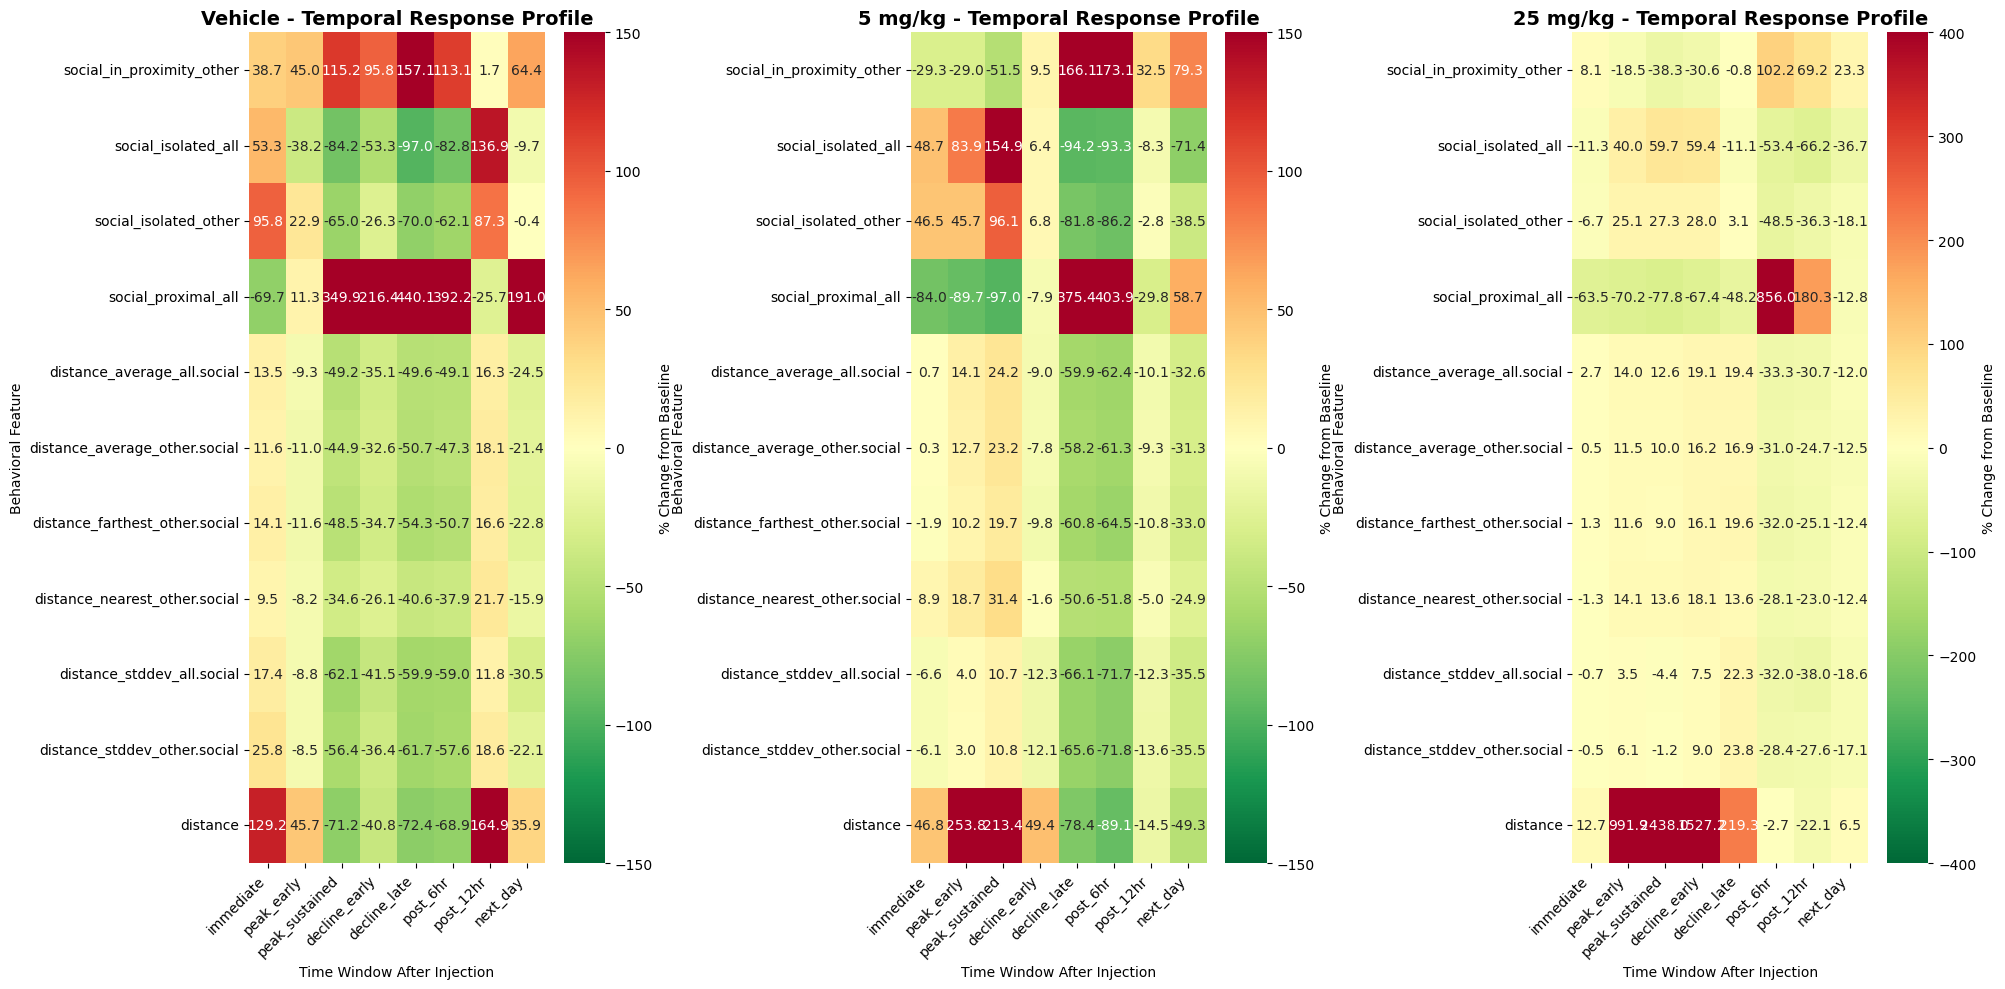

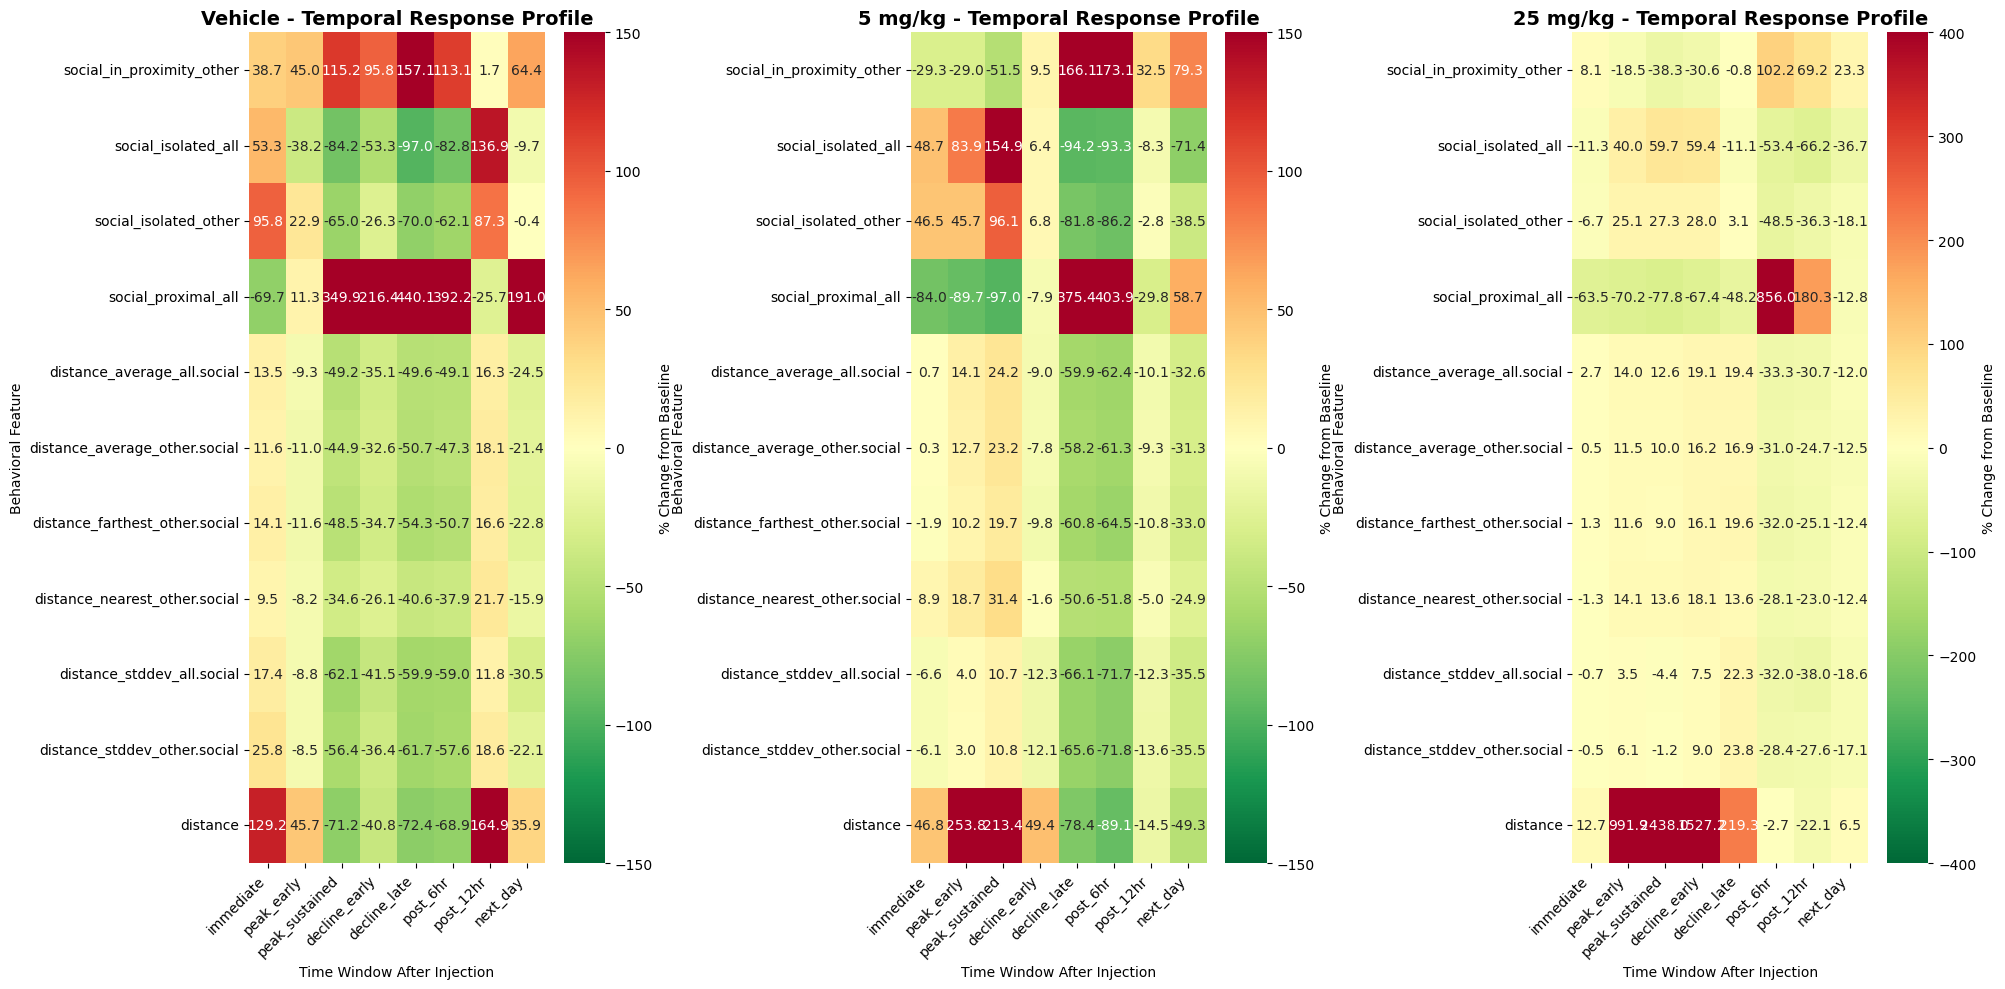

In [62]:
create_all_heatmaps(results)


In [63]:
results.to_csv('percent_change_results.csv', index=False)
print("Results saved to percent_change_results.csv")

Results saved to percent_change_results.csv


In [70]:
def load_cage_data(cage_id, date_str, dose_mapping, file_type='animal_tsdb_mvp'):
    """Load feeding and sleep features from animal_tsdb_mvp."""
    path = f"{S3_BASE}/cage_id={cage_id}/date={date_str}/{file_type}.parquet"
    
    query = f"""
    SELECT * FROM read_parquet('{path}')
    WHERE resolution = 60
    AND name IN ('animal_bouts.feeding', 'animal_bouts.inferred_sleep')
    """
    
    try:
        df = con.execute(query).fetchdf()
        df['cage_id'] = cage_id
        df['dose_group'] = dose_mapping[cage_id]
        return df
    except Exception as e:
        print(f"    ✗ Cage {cage_id}, Date {date_str}: {e}")
        return pd.DataFrame()


Loading: Replicate 1, Dose 1
  Injection time (UTC): 2025-01-14 11:00:00
  Dates to load: ['2025-01-13', '2025-01-14', '2025-01-15']

  Loading date: 2025-01-13
    ✓ Cage 4917 (5 mg/kg): 4,320 rows
    ✓ Cage 4918 (Vehicle): 4,320 rows
    ✓ Cage 4919 (25 mg/kg): 4,320 rows
    ✓ Cage 4920 (25 mg/kg): 4,320 rows
    ✓ Cage 4921 (5 mg/kg): 4,320 rows
    ✓ Cage 4922 (Vehicle): 4,320 rows
    ✓ Cage 4923 (Vehicle): 4,320 rows
    ✓ Cage 4924 (25 mg/kg): 4,140 rows
    ✓ Cage 4925 (5 mg/kg): 4,320 rows

  Loading date: 2025-01-14
    ✓ Cage 4917 (5 mg/kg): 4,320 rows
    ✓ Cage 4918 (Vehicle): 4,320 rows
    ✓ Cage 4919 (25 mg/kg): 4,320 rows
    ✓ Cage 4920 (25 mg/kg): 4,320 rows
    ✓ Cage 4921 (5 mg/kg): 4,320 rows
    ✓ Cage 4922 (Vehicle): 4,320 rows
    ✓ Cage 4923 (Vehicle): 3,600 rows
    ✓ Cage 4924 (25 mg/kg): 4,320 rows
    ✓ Cage 4925 (5 mg/kg): 4,320 rows

  Loading date: 2025-01-15
    ✓ Cage 4917 (5 mg/kg): 4,140 rows
    ✓ Cage 4918 (Vehicle): 4,140 rows
    ✓ Cage 4919 

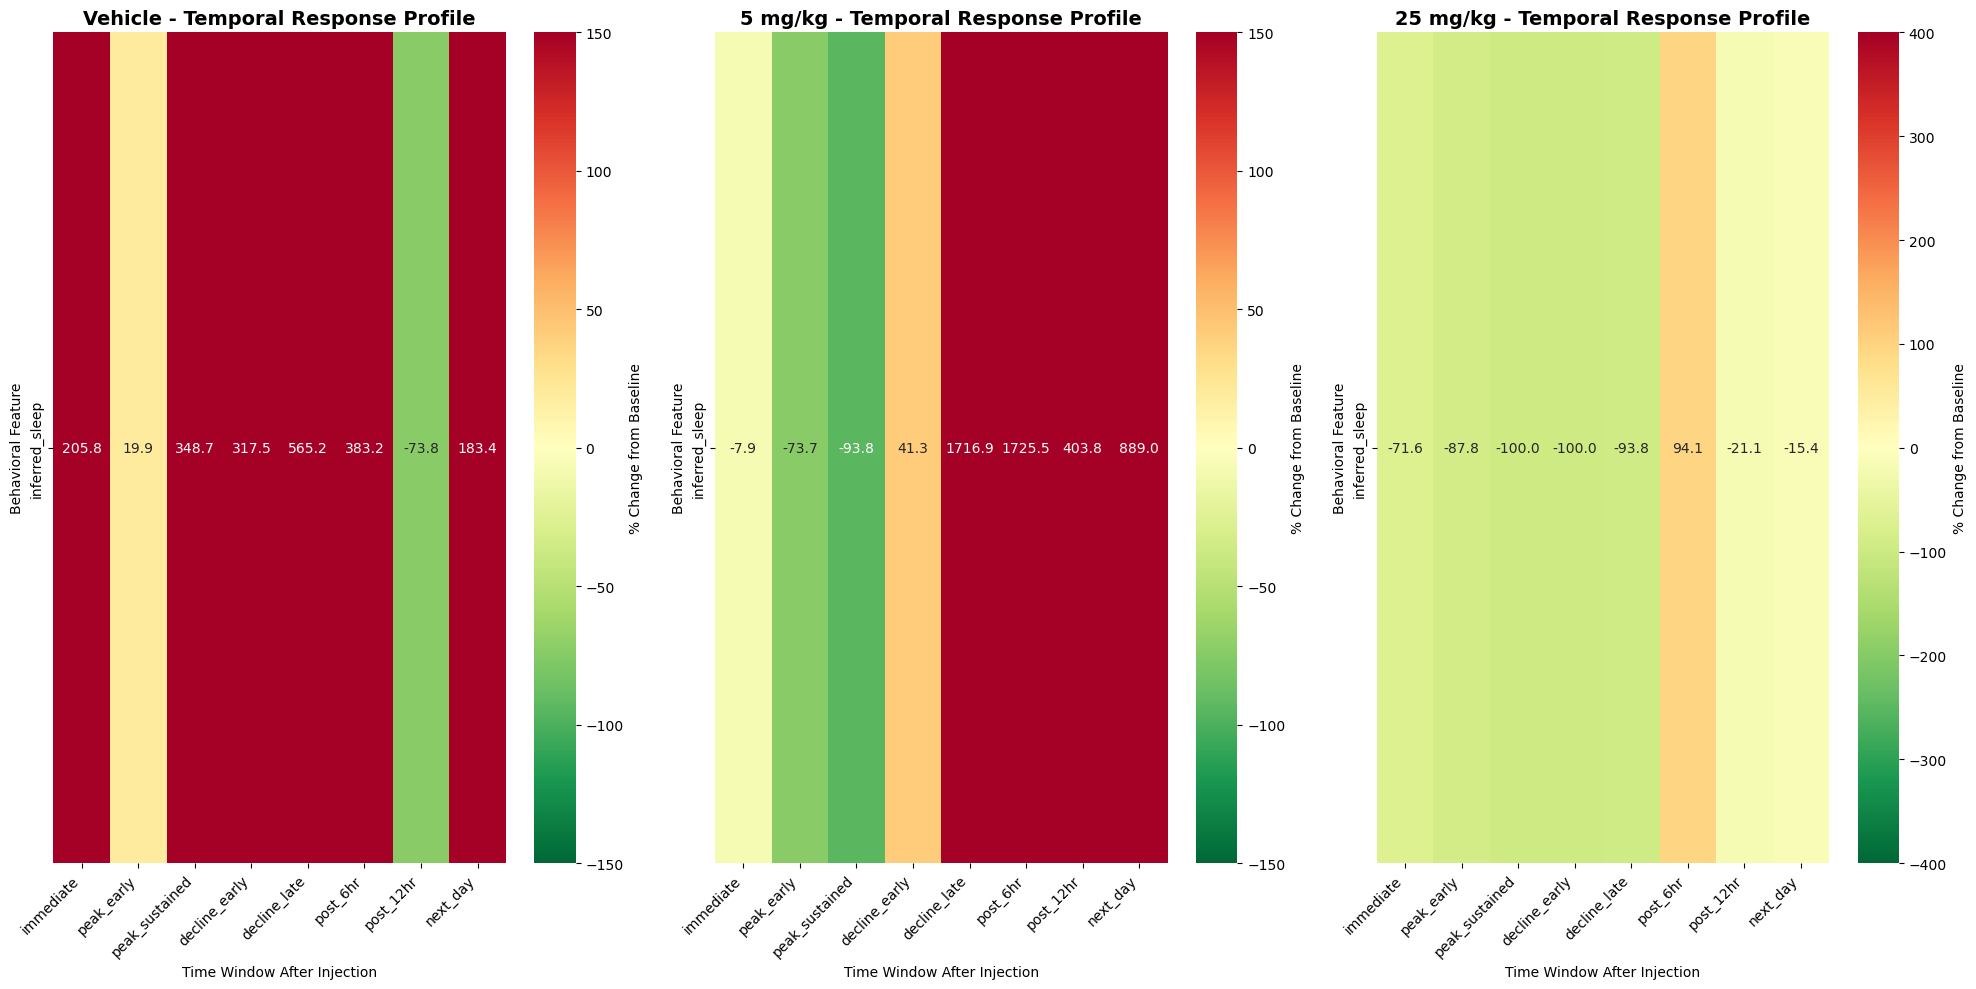

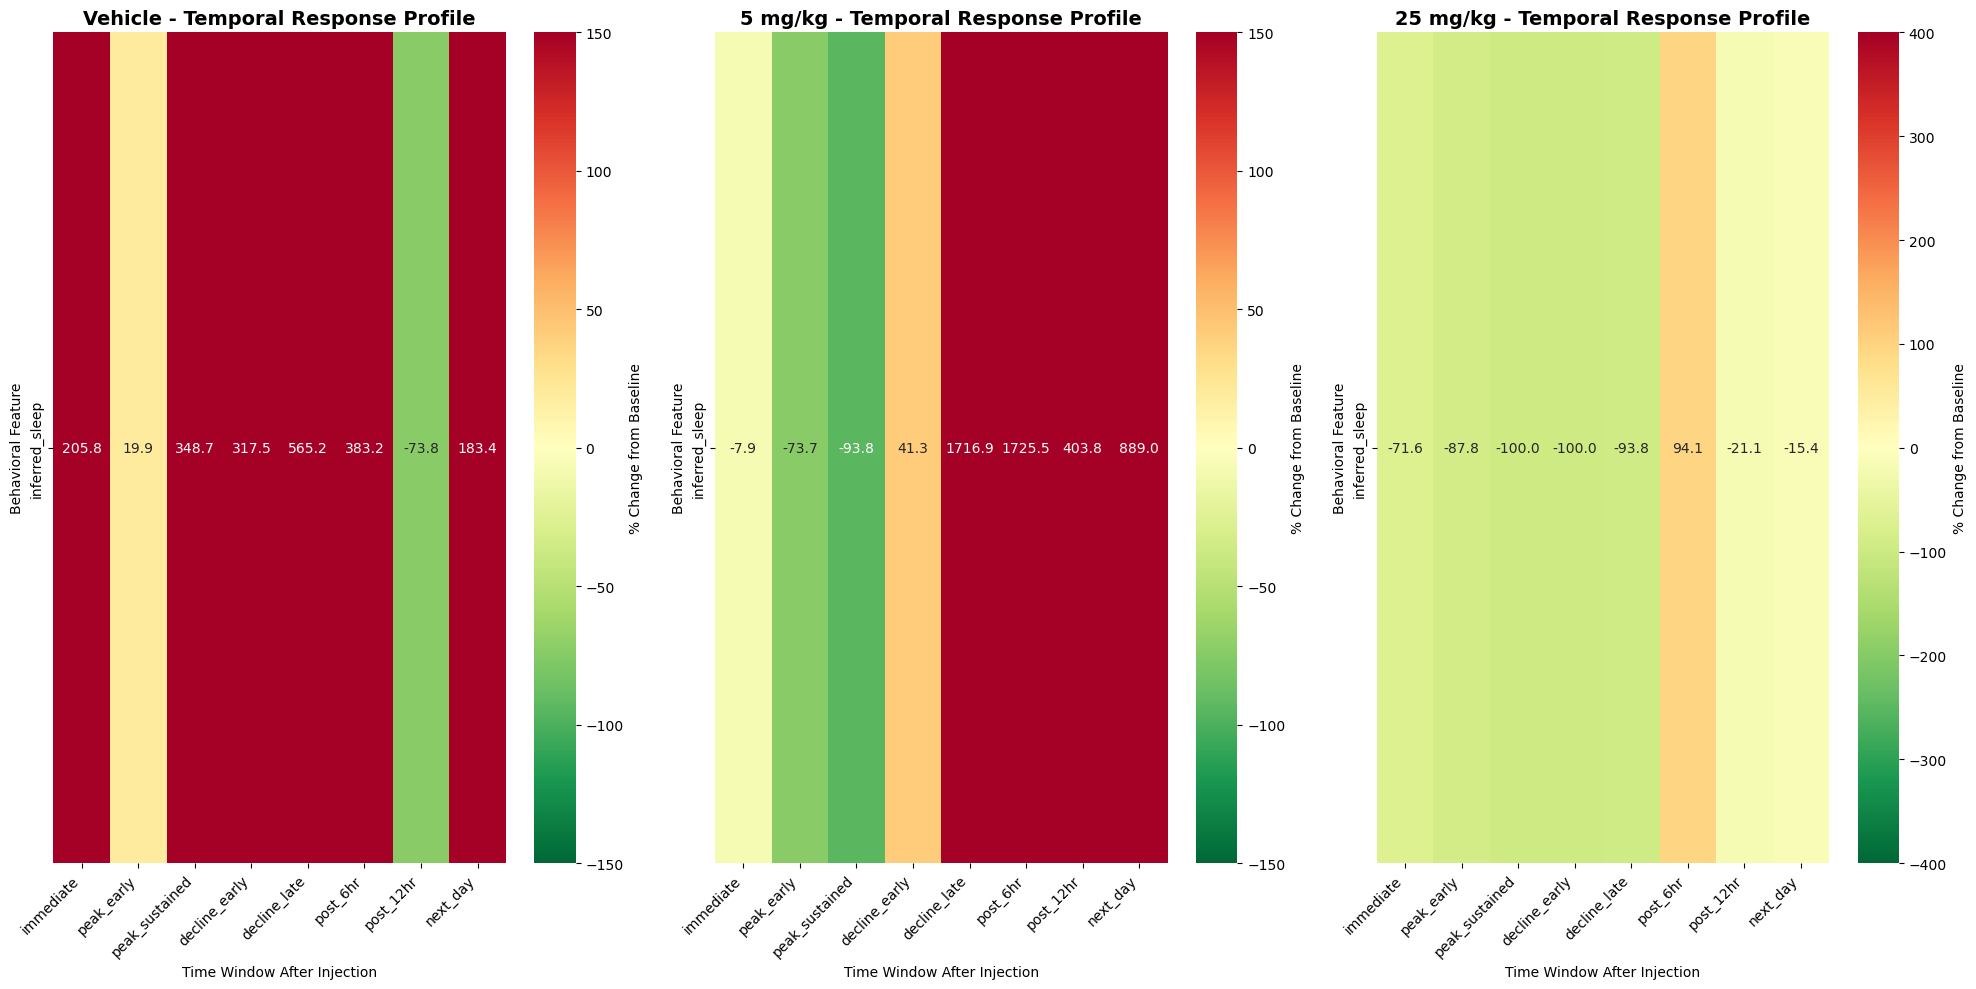

In [71]:
event = INJECTION_EVENTS[0]
df_feeding_sleep = load_injection_event_data(event, resolution=60)

print(df_feeding_sleep['name'].unique())

results_feeding_sleep = compute_percent_change_all_features(df_feeding_sleep)

create_all_heatmaps(results_feeding_sleep)

In [72]:
print(df_feeding_sleep['name'].value_counts())

name
animal_bouts.inferred_sleep    45567
Name: count, dtype: int64


In [73]:
print(df_feeding_sleep[df_feeding_sleep['name'] == 'animal_bouts.feeding']['value'].describe())

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: value, dtype: float64


In [74]:
print(df_feeding_sleep['name'].value_counts())


name
animal_bouts.inferred_sleep    45567
Name: count, dtype: int64


In [77]:
def load_cage_data(cage_id, date_str, dose_mapping, file_type='animal_tsdb_mvp'):
    """Check feeding at all resolutions."""
    path = f"{S3_BASE}/cage_id={cage_id}/date={date_str}/{file_type}.parquet"
    
    query = f"""
    SELECT resolution, COUNT(*) as count 
    FROM read_parquet('{path}')
    WHERE name = 'animal_bouts.feeding'
    GROUP BY resolution
    """
    
    try:
        df = con.execute(query).fetchdf()
        return df
    except Exception as e:
        print(f"    ✗ Cage {cage_id}, Date {date_str}: {e}")
        return pd.DataFrame()

result = load_cage_data(4917, '2025-01-14', DOSE_MAPPING_REP1)
print(result)

   resolution  count
0         600    432
1        3600     72



Loading: Replicate 1, Dose 1
  Injection time (UTC): 2025-01-14 11:00:00
  Dates to load: ['2025-01-13', '2025-01-14', '2025-01-15']

  Loading date: 2025-01-13
    ✓ Cage 4917 (5 mg/kg): 864 rows
    ✓ Cage 4918 (Vehicle): 864 rows
    ✓ Cage 4919 (25 mg/kg): 864 rows
    ✓ Cage 4920 (25 mg/kg): 864 rows
    ✓ Cage 4921 (5 mg/kg): 864 rows
    ✓ Cage 4922 (Vehicle): 864 rows
    ✓ Cage 4923 (Vehicle): 864 rows
    ✓ Cage 4924 (25 mg/kg): 828 rows
    ✓ Cage 4925 (5 mg/kg): 864 rows

  Loading date: 2025-01-14
    ✓ Cage 4917 (5 mg/kg): 864 rows
    ✓ Cage 4918 (Vehicle): 864 rows
    ✓ Cage 4919 (25 mg/kg): 864 rows
    ✓ Cage 4920 (25 mg/kg): 864 rows
    ✓ Cage 4921 (5 mg/kg): 864 rows
    ✓ Cage 4922 (Vehicle): 864 rows
    ✓ Cage 4923 (Vehicle): 720 rows
    ✓ Cage 4924 (25 mg/kg): 864 rows
    ✓ Cage 4925 (5 mg/kg): 864 rows

  Loading date: 2025-01-15
    ✓ Cage 4917 (5 mg/kg): 828 rows
    ✓ Cage 4918 (Vehicle): 828 rows
    ✓ Cage 4919 (25 mg/kg): 756 rows
    ✓ Cage 4920 (25

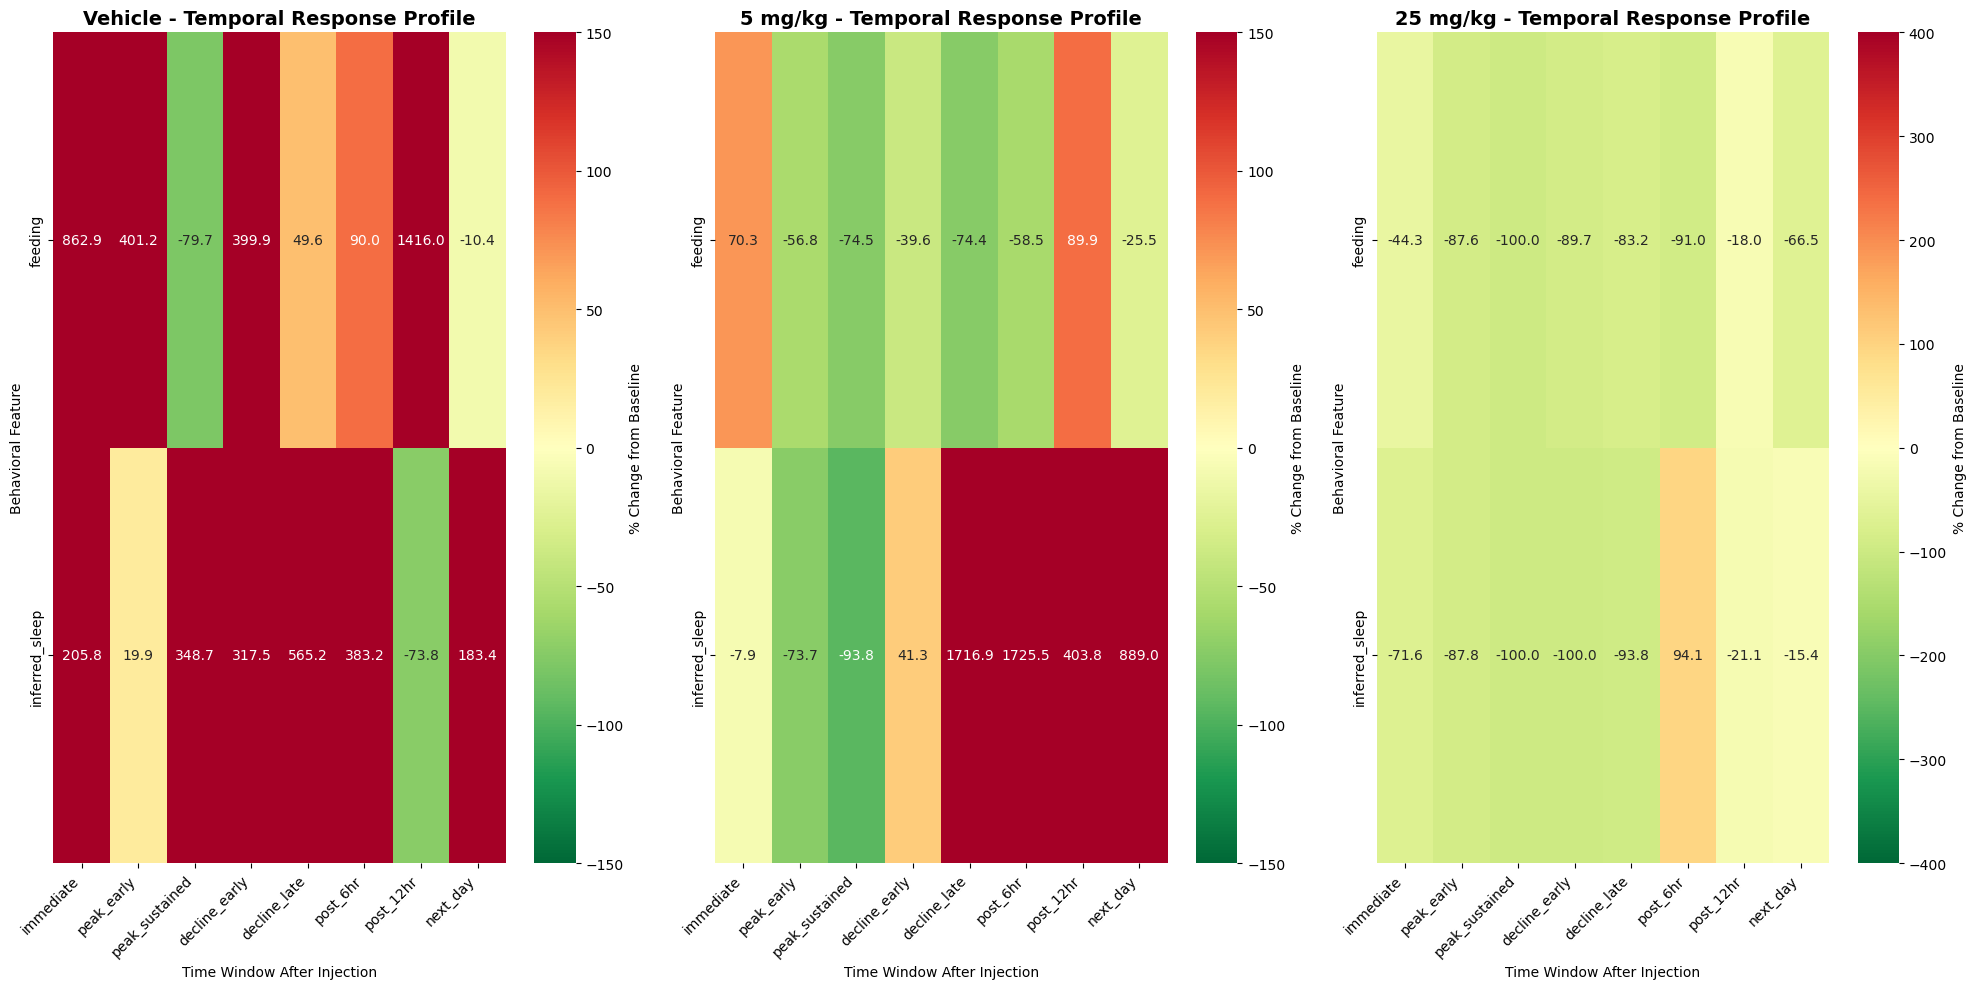

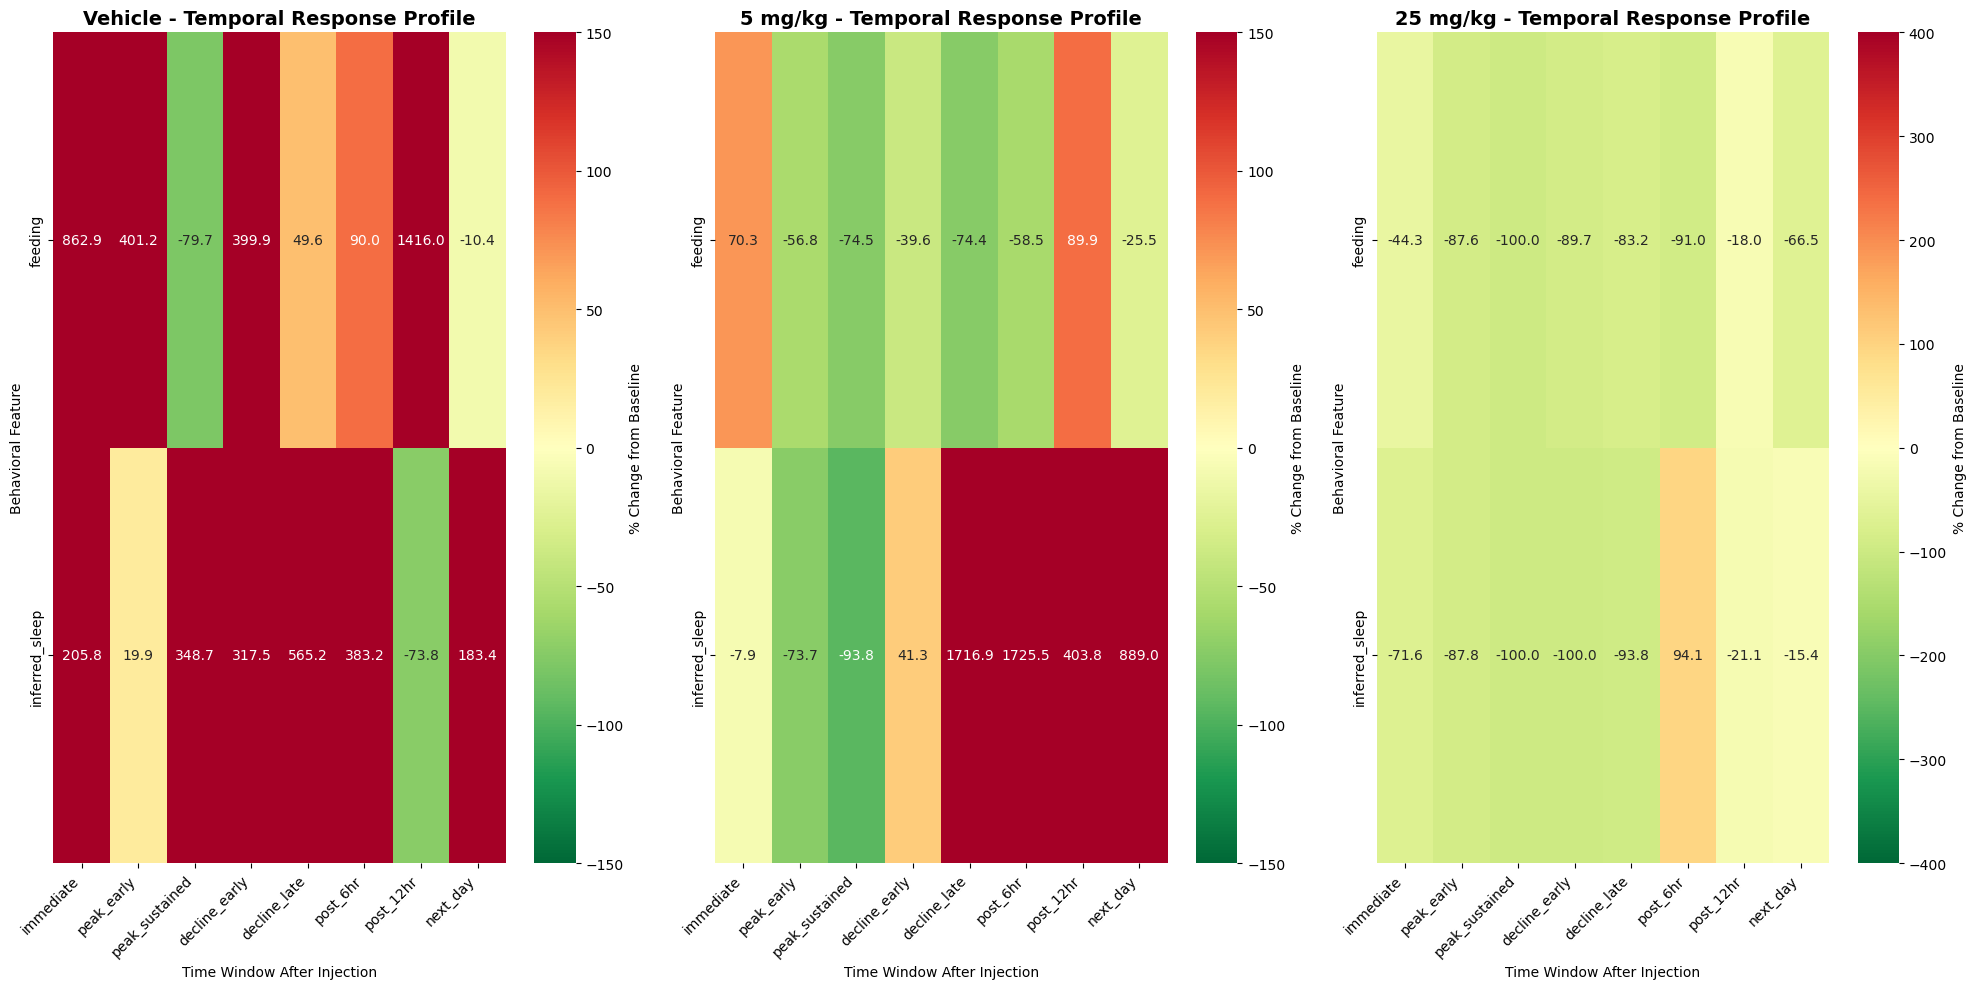

In [78]:
def load_cage_data(cage_id, date_str, dose_mapping, file_type='animal_tsdb_mvp'):
    """Load feeding and sleep features from animal_tsdb_mvp."""
    path = f"{S3_BASE}/cage_id={cage_id}/date={date_str}/{file_type}.parquet"
    
    query = f"""
    SELECT * FROM read_parquet('{path}')
    WHERE resolution = 600
    AND name IN ('animal_bouts.feeding', 'animal_bouts.inferred_sleep')
    """
    
    try:
        df = con.execute(query).fetchdf()
        df['cage_id'] = cage_id
        df['dose_group'] = dose_mapping[cage_id]
        return df
    except Exception as e:
        print(f"    ✗ Cage {cage_id}, Date {date_str}: {e}")
        return pd.DataFrame()

event = INJECTION_EVENTS[0]
df_feeding_sleep = load_injection_event_data(event, resolution=600)

print(df_feeding_sleep['name'].value_counts())

results_feeding_sleep = compute_percent_change_all_features(df_feeding_sleep)

create_all_heatmaps(results_feeding_sleep)

## Drinking Vs Feeding


Loading: Replicate 1, Dose 1
  Injection time (UTC): 2025-01-14 11:00:00
  Dates to load: ['2025-01-13', '2025-01-14', '2025-01-15']

  Loading date: 2025-01-13
    ✓ Cage 4917 (5 mg/kg): 864 rows
    ✓ Cage 4918 (Vehicle): 864 rows
    ✓ Cage 4919 (25 mg/kg): 864 rows
    ✓ Cage 4920 (25 mg/kg): 864 rows
    ✓ Cage 4921 (5 mg/kg): 864 rows
    ✓ Cage 4922 (Vehicle): 864 rows
    ✓ Cage 4923 (Vehicle): 864 rows
    ✓ Cage 4924 (25 mg/kg): 828 rows
    ✓ Cage 4925 (5 mg/kg): 864 rows

  Loading date: 2025-01-14
    ✓ Cage 4917 (5 mg/kg): 864 rows
    ✓ Cage 4918 (Vehicle): 864 rows
    ✓ Cage 4919 (25 mg/kg): 864 rows
    ✓ Cage 4920 (25 mg/kg): 864 rows
    ✓ Cage 4921 (5 mg/kg): 864 rows
    ✓ Cage 4922 (Vehicle): 864 rows
    ✓ Cage 4923 (Vehicle): 720 rows
    ✓ Cage 4924 (25 mg/kg): 864 rows
    ✓ Cage 4925 (5 mg/kg): 864 rows

  Loading date: 2025-01-15
    ✓ Cage 4917 (5 mg/kg): 828 rows
    ✓ Cage 4918 (Vehicle): 828 rows
    ✓ Cage 4919 (25 mg/kg): 756 rows
    ✓ Cage 4920 (25

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4917 (5 mg/kg): 792 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4918 (Vehicle): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4919 (25 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4920 (25 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4921 (5 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4922 (Vehicle): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4923 (Vehicle): 756 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4924 (25 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4925 (5 mg/kg): 864 rows

  Loading date: 2025-01-18


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4917 (5 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4918 (Vehicle): 828 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4919 (25 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4920 (25 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4921 (5 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4922 (Vehicle): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4923 (Vehicle): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4924 (25 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4925 (5 mg/kg): 864 rows

  Loading date: 2025-01-19


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4917 (5 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4918 (Vehicle): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4919 (25 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4920 (25 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4921 (5 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4922 (Vehicle): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4923 (Vehicle): 828 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4924 (25 mg/kg): 792 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4925 (5 mg/kg): 864 rows

  Total rows loaded: 23,004
  Filtered data: 9,414 rows
  Features: ['animal_bouts.drinking', 'animal_bouts.feeding']

Loading: Replicate 2, Dose 1
  Injection time (UTC): 2025-01-28 22:00:00
  Dates to load: ['2025-01-28', '2025-01-29', '2025-01-30']

  Loading date: 2025-01-28


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4926 (25 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4927 (5 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4928 (Vehicle): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4929 (Vehicle): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4930 (25 mg/kg): 792 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4931 (5 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4932 (5 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4933 (25 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4934 (Vehicle): 864 rows

  Loading date: 2025-01-29


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4926 (25 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4927 (5 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4928 (Vehicle): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4929 (Vehicle): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4930 (25 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4931 (5 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4932 (5 mg/kg): 756 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4933 (25 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4934 (Vehicle): 864 rows

  Loading date: 2025-01-30


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4926 (25 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4927 (5 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4928 (Vehicle): 828 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4929 (Vehicle): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4930 (25 mg/kg): 756 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4931 (5 mg/kg): 828 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4932 (5 mg/kg): 828 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4933 (25 mg/kg): 828 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4934 (Vehicle): 864 rows

  Total rows loaded: 22,896
  Filtered data: 9,342 rows
  Features: ['animal_bouts.drinking', 'animal_bouts.feeding']

Loading: Replicate 2, Dose 2
  Injection time (UTC): 2025-01-31 11:00:00
  Dates to load: ['2025-01-30', '2025-01-31', '2025-02-01']

  Loading date: 2025-01-30
    ✓ Cage 4926 (25 mg/kg): 864 rows
    ✓ Cage 4927 (5 mg/kg): 864 rows
    ✓ Cage 4928 (Vehicle): 828 rows
    ✓ Cage 4929 (Vehicle): 864 rows
    ✓ Cage 4930 (25 mg/kg): 756 rows
    ✓ Cage 4931 (5 mg/kg): 828 rows
    ✓ Cage 4932 (5 mg/kg): 828 rows
    ✓ Cage 4933 (25 mg/kg): 828 rows
    ✓ Cage 4934 (Vehicle): 864 rows

  Loading date: 2025-01-31


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4926 (25 mg/kg): 828 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4927 (5 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4928 (Vehicle): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4929 (Vehicle): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4930 (25 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4931 (5 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4932 (5 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4933 (25 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4934 (Vehicle): 864 rows

  Loading date: 2025-02-01


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4926 (25 mg/kg): 756 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4927 (5 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4928 (Vehicle): 792 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4929 (Vehicle): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4930 (25 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4931 (5 mg/kg): 828 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4932 (5 mg/kg): 828 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4933 (25 mg/kg): 864 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4934 (Vehicle): 828 rows

  Total rows loaded: 22,752
  Filtered data: 9,306 rows
  Features: ['animal_bouts.drinking', 'animal_bouts.feeding']

TOTAL: 37,224 rows, 2 features, 54 animals

Computing percent change for 2 features...
  [1/2] animal_bouts.feeding
  [2/2] animal_bouts.drinking

Results: 1,660 rows


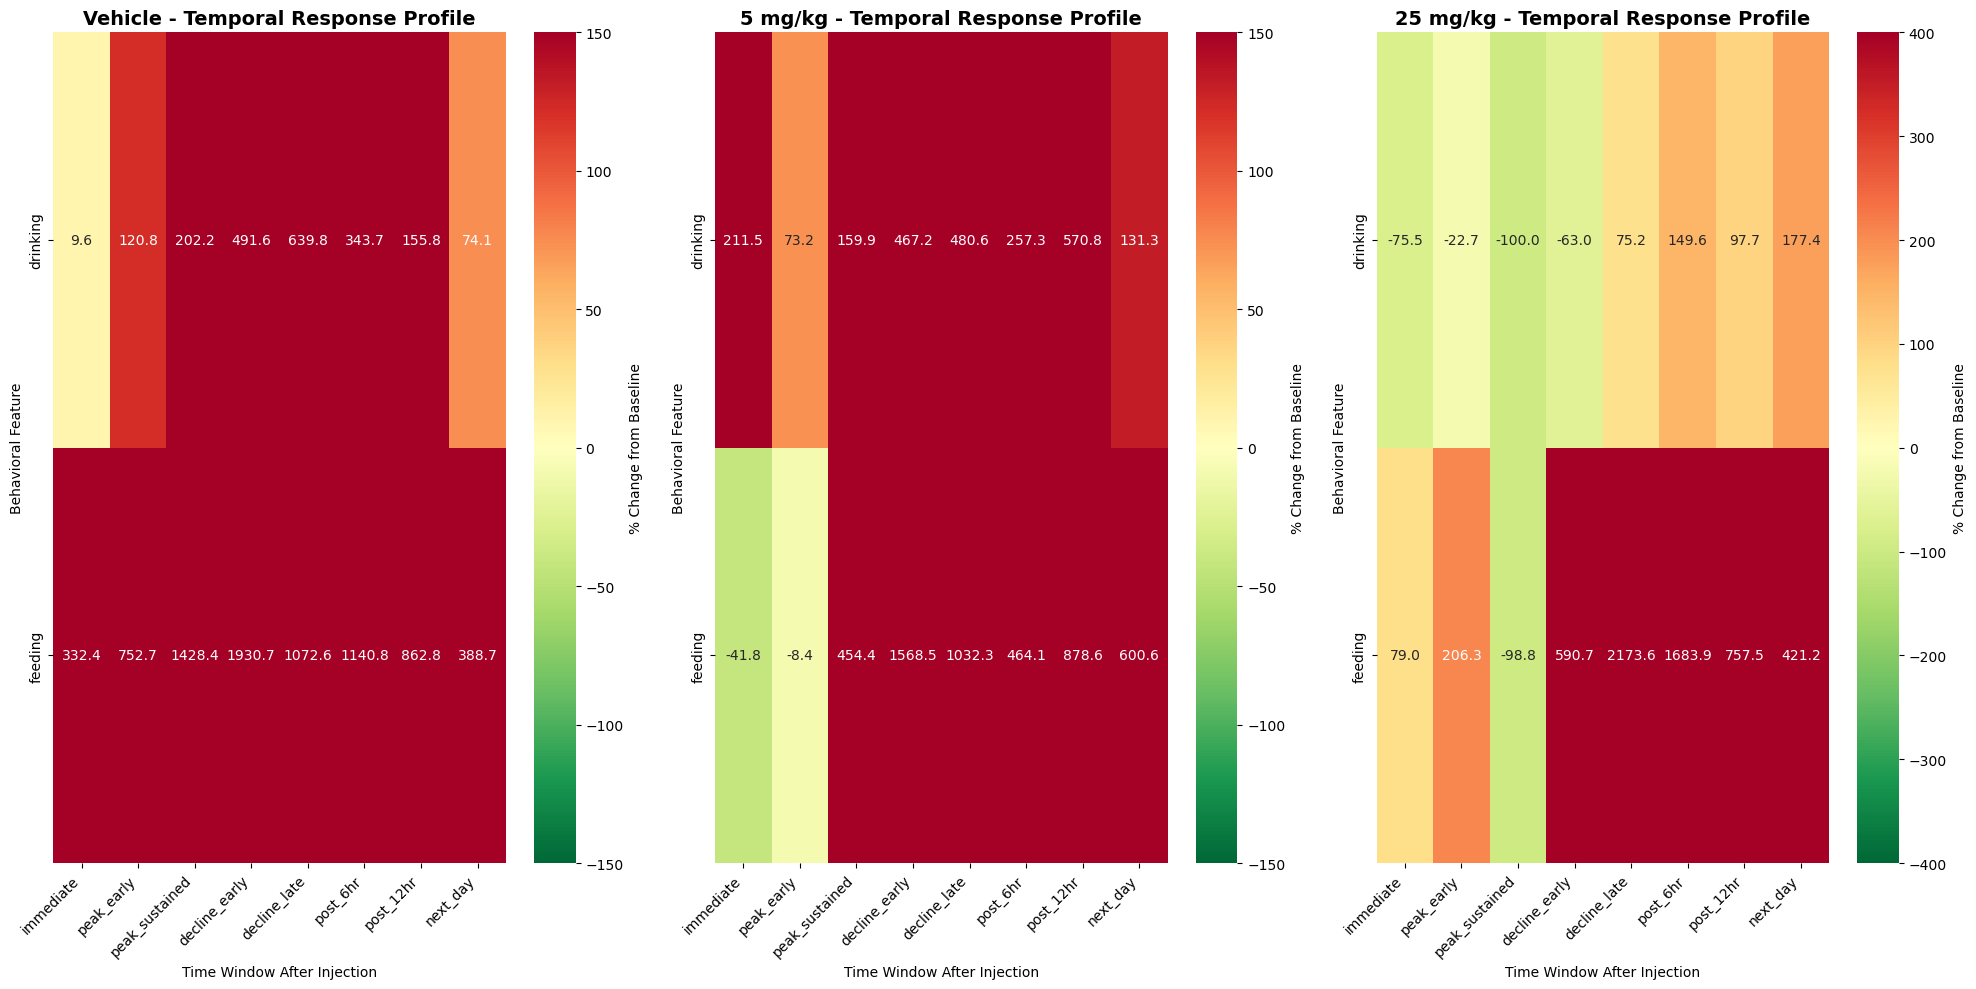

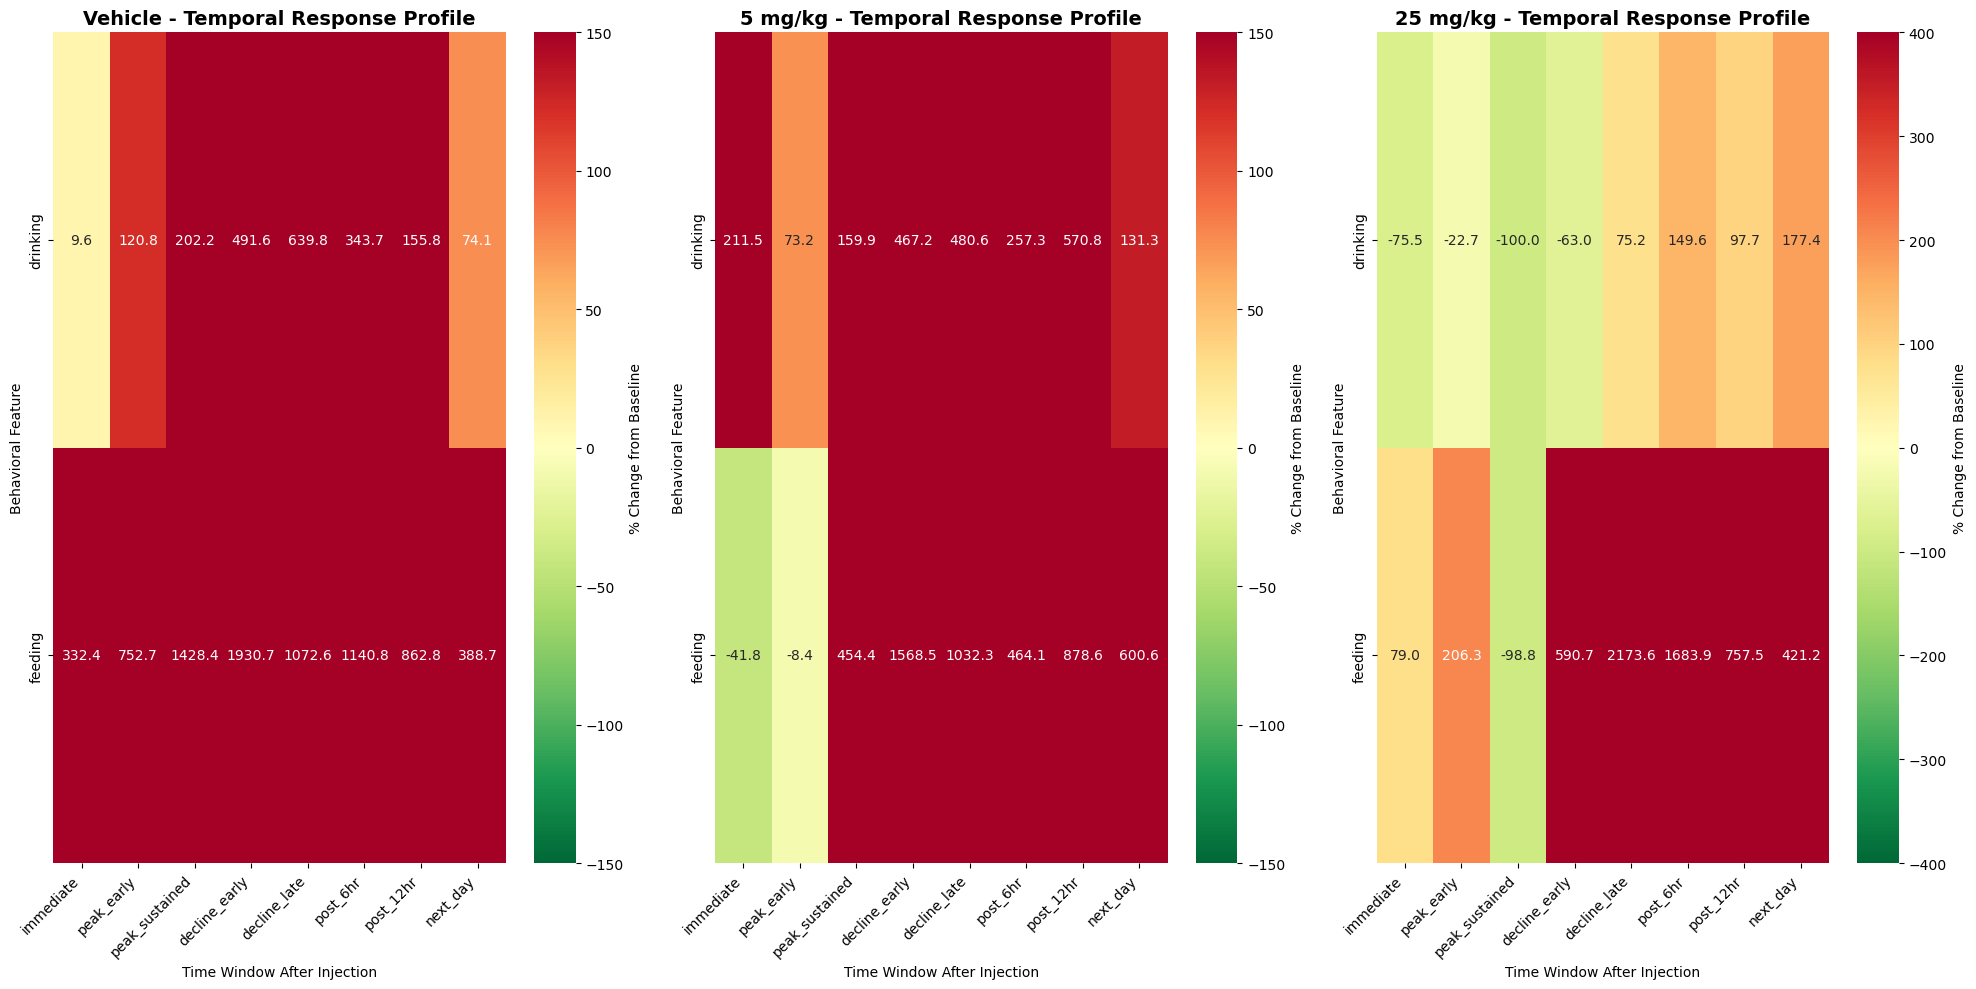

In [82]:
def load_cage_data(cage_id, date_str, dose_mapping, file_type='animal_tsdb_mvp'):
    """Load drinking and feeding features."""
    path = f"{S3_BASE}/cage_id={cage_id}/date={date_str}/{file_type}.parquet"
    
    query = f"""
    SELECT * FROM read_parquet('{path}')
    WHERE resolution = 600
    AND name IN ('animal_bouts.drinking', 'animal_bouts.feeding')
    """
    
    try:
        df = con.execute(query).fetchdf()
        df['cage_id'] = cage_id
        df['dose_group'] = dose_mapping[cage_id]
        return df
    except Exception as e:
        print(f"    ✗ Cage {cage_id}, Date {date_str}: {e}")
        return pd.DataFrame()

df_all_events = load_all_events(resolution=600)
results_all_events = compute_percent_change_all_features(df_all_events)
create_all_heatmaps(results_all_events)

## Individual consistency analysis


Loading: Replicate 1, Dose 1
  Injection time (UTC): 2025-01-14 11:00:00
  Dates to load: ['2025-01-13', '2025-01-14', '2025-01-15']

  Loading date: 2025-01-13
    ✓ Cage 4917 (5 mg/kg): 4,279 rows
    ✓ Cage 4918 (Vehicle): 4,289 rows
    ✓ Cage 4919 (25 mg/kg): 4,271 rows
    ✓ Cage 4920 (25 mg/kg): 4,299 rows
    ✓ Cage 4921 (5 mg/kg): 4,307 rows
    ✓ Cage 4922 (Vehicle): 4,241 rows
    ✓ Cage 4923 (Vehicle): 4,260 rows
    ✓ Cage 4924 (25 mg/kg): 4,058 rows
    ✓ Cage 4925 (5 mg/kg): 4,206 rows

  Loading date: 2025-01-14
    ✓ Cage 4917 (5 mg/kg): 4,297 rows
    ✓ Cage 4918 (Vehicle): 4,181 rows
    ✓ Cage 4919 (25 mg/kg): 4,313 rows
    ✓ Cage 4920 (25 mg/kg): 4,401 rows
    ✓ Cage 4921 (5 mg/kg): 4,315 rows
    ✓ Cage 4922 (Vehicle): 4,208 rows
    ✓ Cage 4923 (Vehicle): 3,534 rows
    ✓ Cage 4924 (25 mg/kg): 4,274 rows
    ✓ Cage 4925 (5 mg/kg): 4,333 rows

  Loading date: 2025-01-15
    ✓ Cage 4917 (5 mg/kg): 4,058 rows
    ✓ Cage 4918 (Vehicle): 4,051 rows
    ✓ Cage 4919 

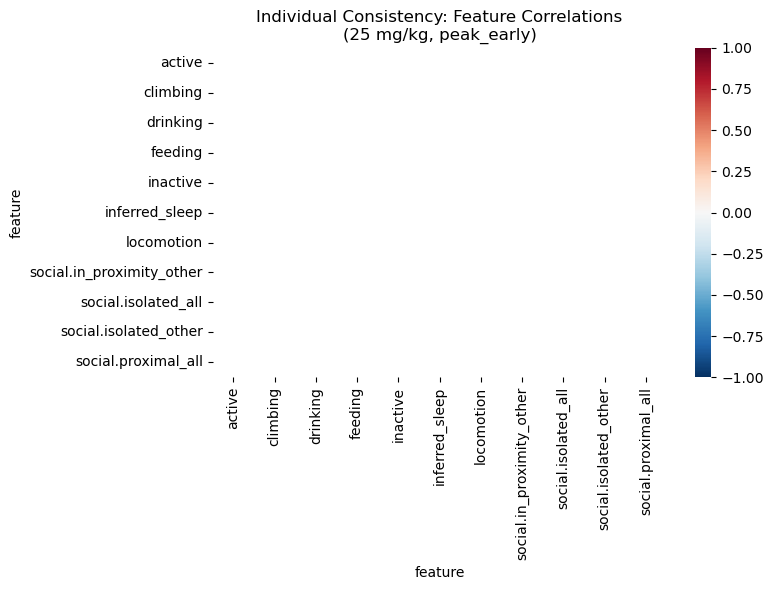

In [80]:
def individual_consistency_analysis(results_df, dose_group='25 mg/kg', window='peak_early'):
    """
    Correlate effect sizes across features within individuals.
    """
    # Filter to one dose and window
    subset = results_df[
        (results_df['dose_group'] == dose_group) &
        (results_df['window'] == window)
    ]
    
    # Pivot: rows = animals, columns = features
    pivot = subset.pivot_table(
        index=['animal_id', 'event'],
        columns='feature',
        values='pct_change'
    ).dropna()
    
    # Clean column names
    pivot.columns = pivot.columns.str.replace('animal_bouts.', '')
    
    print(f"Animals with complete data: {len(pivot)}")
    print(f"Features: {list(pivot.columns)}")
    
    # Correlation matrix
    corr = pivot.corr()
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                vmin=-1, vmax=1, ax=ax)
    ax.set_title(f'Individual Consistency: Feature Correlations\n({dose_group}, {window})')
    plt.tight_layout()
    plt.show()
    
    return pivot, corr


# First, load ALL features to do this properly
def load_cage_data(cage_id, date_str, dose_mapping, file_type='animal_tsdb_mvp'):
    """Load all behavioral features."""
    path = f"{S3_BASE}/cage_id={cage_id}/date={date_str}/{file_type}.parquet"
    
    query = f"""
    SELECT * FROM read_parquet('{path}')
    WHERE resolution = 600
    AND name LIKE 'animal_bouts%'
    """
    
    try:
        df = con.execute(query).fetchdf()
        df['cage_id'] = cage_id
        df['dose_group'] = dose_mapping[cage_id]
        return df
    except Exception as e:
        print(f"    ✗ Cage {cage_id}, Date {date_str}: {e}")
        return pd.DataFrame()

# Load data
event = INJECTION_EVENTS[0]
df_all_bouts = load_injection_event_data(event, resolution=600)

print(df_all_bouts['name'].value_counts())

# Compute percent change
results_all = compute_percent_change_all_features(df_all_bouts)

# Run individual consistency analysis
pivot, corr = individual_consistency_analysis(results_all, dose_group='25 mg/kg', window='peak_early')

In [81]:
def check_features(cage_id, date_str, dose_mapping, file_type='animal_activity_db'):
    path = f"{S3_BASE}/cage_id={cage_id}/date={date_str}/{file_type}.parquet"
    
    query = f"""
    SELECT DISTINCT name FROM read_parquet('{path}')
    """
    
    try:
        df = con.execute(query).fetchdf()
        return df
    except Exception as e:
        return pd.DataFrame()

result = check_features(4917, '2025-01-14', DOSE_MAPPING_REP1)
print(result)

                      name
0  animal_bouts.locomotion
1    animal_bouts.inactive
2      animal_bouts.active
3    animal_bouts.climbing


In [84]:
pd.set_option('display.max_colwidth', None)


In [85]:
query = f"""
SELECT * FROM glob('{S3_BASE}/cage_id=4917/date=2025-01-14/*.parquet')
"""
con.execute(query).fetchdf()

,file
0,s3://jax-envision-public-data/study_1001/2025v3.3/tabular/cage_id=4917/date=2025-01-14/animal_activity_db.parquet
1,s3://jax-envision-public-data/study_1001/2025v3.3/tabular/cage_id=4917/date=2025-01-14/animal_activity_features.parquet
2,s3://jax-envision-public-data/study_1001/2025v3.3/tabular/cage_id=4917/date=2025-01-14/animal_activity_state_bboxes.parquet
3,s3://jax-envision-public-data/study_1001/2025v3.3/tabular/cage_id=4917/date=2025-01-14/animal_aggs_long_id.parquet
4,s3://jax-envision-public-data/study_1001/2025v3.3/tabular/cage_id=4917/date=2025-01-14/animal_aggs_short_id.parquet
5,s3://jax-envision-public-data/study_1001/2025v3.3/tabular/cage_id=4917/date=2025-01-14/animal_bout_metrics.parquet
6,s3://jax-envision-public-data/study_1001/2025v3.3/tabular/cage_id=4917/date=2025-01-14/animal_bouts.parquet
7,s3://jax-envision-public-data/study_1001/2025v3.3/tabular/cage_id=4917/date=2025-01-14/animal_drinking.parquet
8,s3://jax-envision-public-data/study_1001/2025v3.3/tabular/cage_id=4917/date=2025-01-14/animal_eartags.parquet
9,s3://jax-envision-public-data/study_1001/2025v3.3/tabular/cage_id=4917/date=2025-01-14/animal_ids.parquet


In [86]:
query = f"""
SELECT DISTINCT name, resolution, COUNT(*) as count
FROM read_parquet('{S3_BASE}/cage_id=4917/date=2025-01-14/animal_drinking.parquet')
GROUP BY name, resolution
ORDER BY name, resolution
"""
con.execute(query).fetchdf()

,name,resolution,count
0,animal_bouts.drinking,1,259020
1,animal_bouts.drinking,10,25902
2,animal_bouts.drinking,60,4317
3,animal_bouts.feeding,1,259020
4,animal_bouts.feeding,10,25902
5,animal_bouts.feeding,60,4317



Loading: Replicate 1, Dose 1
  Injection time (UTC): 2025-01-14 11:00:00
  Dates to load: ['2025-01-13', '2025-01-14', '2025-01-15']

  Loading date: 2025-01-13


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4917 (5 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4918 (Vehicle): 8,634 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4919 (25 mg/kg): 8,634 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4920 (25 mg/kg): 8,634 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4921 (5 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4922 (Vehicle): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4923 (Vehicle): 8,634 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4924 (25 mg/kg): 8,634 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4925 (5 mg/kg): 8,640 rows

  Loading date: 2025-01-14


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4917 (5 mg/kg): 8,634 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4918 (Vehicle): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4919 (25 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4920 (25 mg/kg): 8,628 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4921 (5 mg/kg): 8,634 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4922 (Vehicle): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4923 (Vehicle): 8,280 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4924 (25 mg/kg): 8,634 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4925 (5 mg/kg): 8,640 rows

  Loading date: 2025-01-15


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4917 (5 mg/kg): 8,280 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4918 (Vehicle): 8,280 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4919 (25 mg/kg): 8,280 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4920 (25 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4921 (5 mg/kg): 8,280 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4922 (Vehicle): 8,280 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4923 (Vehicle): 8,280 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4924 (25 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4925 (5 mg/kg): 8,280 rows

  Total rows loaded: 230,340
  Filtered data: 93,264 rows
  Features: ['animal_bouts.drinking', 'animal_bouts.feeding']

Loading: Replicate 1, Dose 2
  Injection time (UTC): 2025-01-17 22:00:00
  Dates to load: ['2025-01-17', '2025-01-18', '2025-01-19']

  Loading date: 2025-01-17


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4917 (5 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4918 (Vehicle): 8,634 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4919 (25 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4920 (25 mg/kg): 8,628 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4921 (5 mg/kg): 8,634 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4922 (Vehicle): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4923 (Vehicle): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4924 (25 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4925 (5 mg/kg): 8,634 rows

  Loading date: 2025-01-18


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4917 (5 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4918 (Vehicle): 8,280 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4919 (25 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4920 (25 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4921 (5 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4922 (Vehicle): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4923 (Vehicle): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4924 (25 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4925 (5 mg/kg): 8,640 rows

  Loading date: 2025-01-19


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4917 (5 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4918 (Vehicle): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4919 (25 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4920 (25 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4921 (5 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4922 (Vehicle): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4923 (Vehicle): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4924 (25 mg/kg): 7,920 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4925 (5 mg/kg): 8,640 rows

  Total rows loaded: 232,170
  Filtered data: 93,624 rows
  Features: ['animal_bouts.drinking', 'animal_bouts.feeding']

Loading: Replicate 2, Dose 1
  Injection time (UTC): 2025-01-28 22:00:00
  Dates to load: ['2025-01-28', '2025-01-29', '2025-01-30']

  Loading date: 2025-01-28


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4926 (25 mg/kg): 8,634 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4927 (5 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4928 (Vehicle): 8,628 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4929 (Vehicle): 8,634 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4930 (25 mg/kg): 8,634 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4931 (5 mg/kg): 8,634 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4932 (5 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4933 (25 mg/kg): 8,610 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4934 (Vehicle): 8,640 rows

  Loading date: 2025-01-29


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4926 (25 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4927 (5 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4928 (Vehicle): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4929 (Vehicle): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4930 (25 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4931 (5 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4932 (5 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4933 (25 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4934 (Vehicle): 8,640 rows

  Loading date: 2025-01-30


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4926 (25 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4927 (5 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4928 (Vehicle): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4929 (Vehicle): 8,634 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4930 (25 mg/kg): 7,920 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4931 (5 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4932 (5 mg/kg): 8,280 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4933 (25 mg/kg): 8,634 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4934 (Vehicle): 8,640 rows

  Total rows loaded: 232,122
  Filtered data: 93,948 rows
  Features: ['animal_bouts.drinking', 'animal_bouts.feeding']

Loading: Replicate 2, Dose 2
  Injection time (UTC): 2025-01-31 11:00:00
  Dates to load: ['2025-01-30', '2025-01-31', '2025-02-01']

  Loading date: 2025-01-30
    ✓ Cage 4926 (25 mg/kg): 8,640 rows
    ✓ Cage 4927 (5 mg/kg): 8,640 rows
    ✓ Cage 4928 (Vehicle): 8,640 rows
    ✓ Cage 4929 (Vehicle): 8,634 rows
    ✓ Cage 4930 (25 mg/kg): 7,920 rows
    ✓ Cage 4931 (5 mg/kg): 8,640 rows
    ✓ Cage 4932 (5 mg/kg): 8,280 rows
    ✓ Cage 4933 (25 mg/kg): 8,634 rows
    ✓ Cage 4934 (Vehicle): 8,640 rows

  Loading date: 2025-01-31


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4926 (25 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4927 (5 mg/kg): 8,634 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4928 (Vehicle): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4929 (Vehicle): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4930 (25 mg/kg): 8,634 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4931 (5 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4932 (5 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4933 (25 mg/kg): 8,634 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4934 (Vehicle): 8,634 rows

  Loading date: 2025-02-01


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4926 (25 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4927 (5 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4928 (Vehicle): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4929 (Vehicle): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4930 (25 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4931 (5 mg/kg): 8,280 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4932 (5 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4933 (25 mg/kg): 8,640 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

    ✓ Cage 4934 (Vehicle): 8,280 rows

  Total rows loaded: 231,444
  Filtered data: 93,990 rows
  Features: ['animal_bouts.drinking', 'animal_bouts.feeding']

TOTAL: 374,826 rows, 2 features, 54 animals
name
animal_bouts.drinking    187413
animal_bouts.feeding     187413
Name: count, dtype: int64

Computing percent change for 2 features...
  [1/2] animal_bouts.drinking
  [2/2] animal_bouts.feeding

Results: 1,666 rows


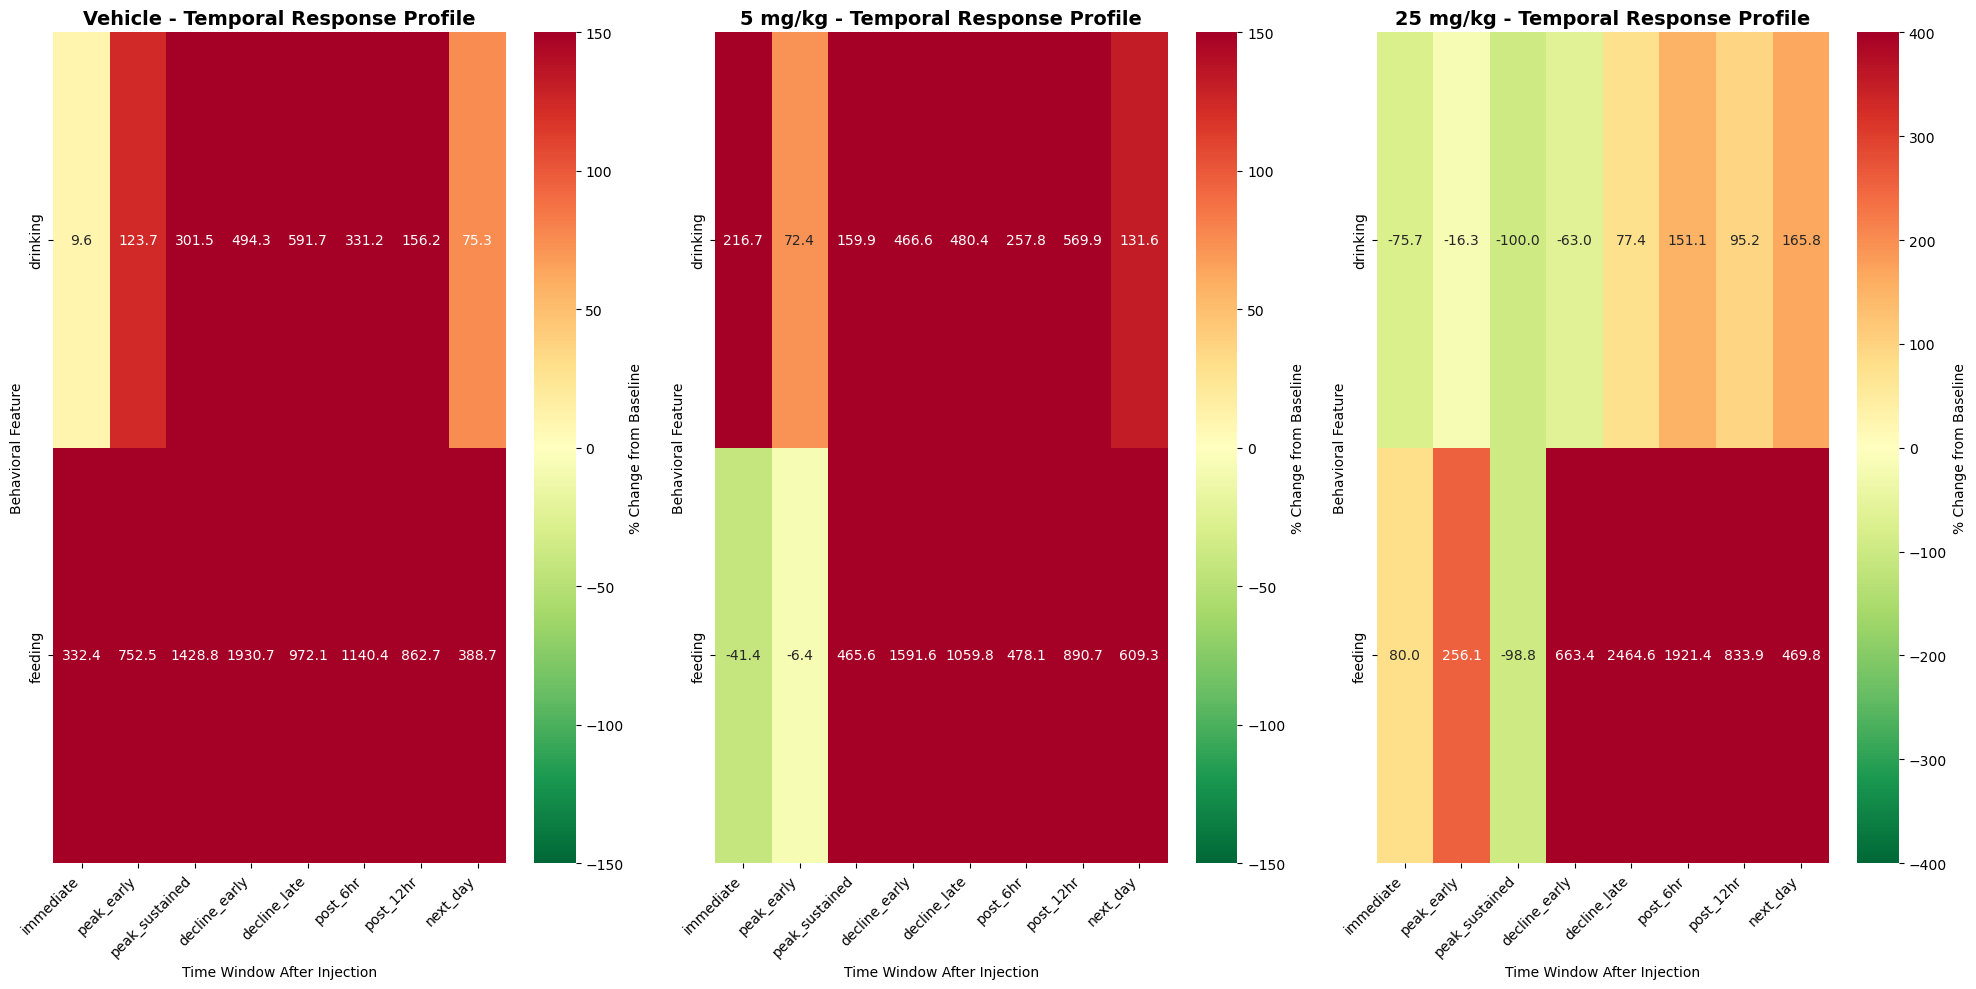

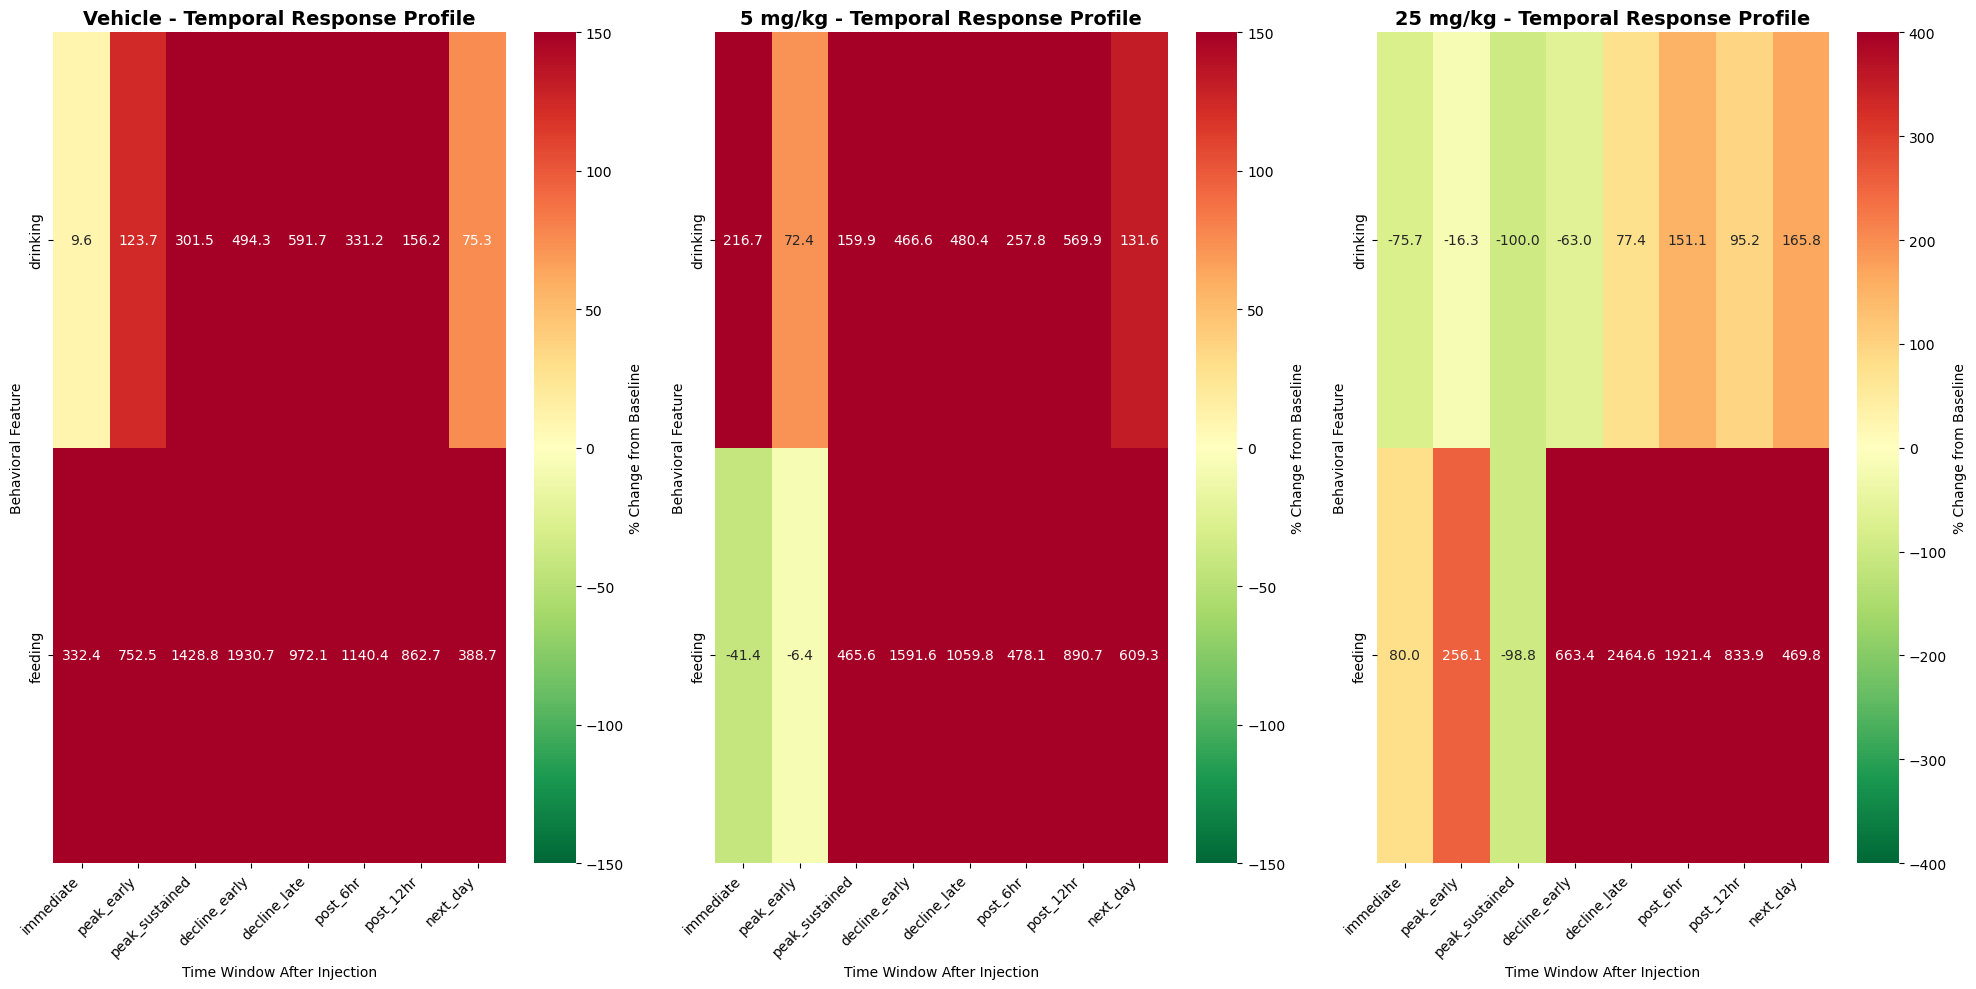

In [87]:
def load_cage_data(cage_id, date_str, dose_mapping, file_type='animal_drinking'):
    """Load drinking and feeding from animal_drinking.parquet."""
    path = f"{S3_BASE}/cage_id={cage_id}/date={date_str}/{file_type}.parquet"
    
    query = f"""
    SELECT * FROM read_parquet('{path}')
    WHERE resolution = 60
    """
    
    try:
        df = con.execute(query).fetchdf()
        df['cage_id'] = cage_id
        df['dose_group'] = dose_mapping[cage_id]
        return df
    except Exception as e:
        print(f"    ✗ Cage {cage_id}, Date {date_str}: {e}")
        return pd.DataFrame()

# Load all replicates
df_drinking = load_all_events(resolution=60)

print(df_drinking['name'].value_counts())

results_drinking = compute_percent_change_all_features(df_drinking)

create_all_heatmaps(results_drinking)

In [88]:
baseline_data = df_drinking[
    (df_drinking['minutes_from_injection'] >= -180) &
    (df_drinking['minutes_from_injection'] < -60)
]
print(baseline_data.groupby('name')['value'].describe())

                         count      mean       std  min  25%  50%  75%  \
name                                                                     
animal_bouts.drinking  12939.0  0.002575  0.023388  0.0  0.0  0.0  0.0   
animal_bouts.feeding   12939.0  0.037601  0.137729  0.0  0.0  0.0  0.0   

                            max  
name                             
animal_bouts.drinking  0.816667  
animal_bouts.feeding   1.000000  


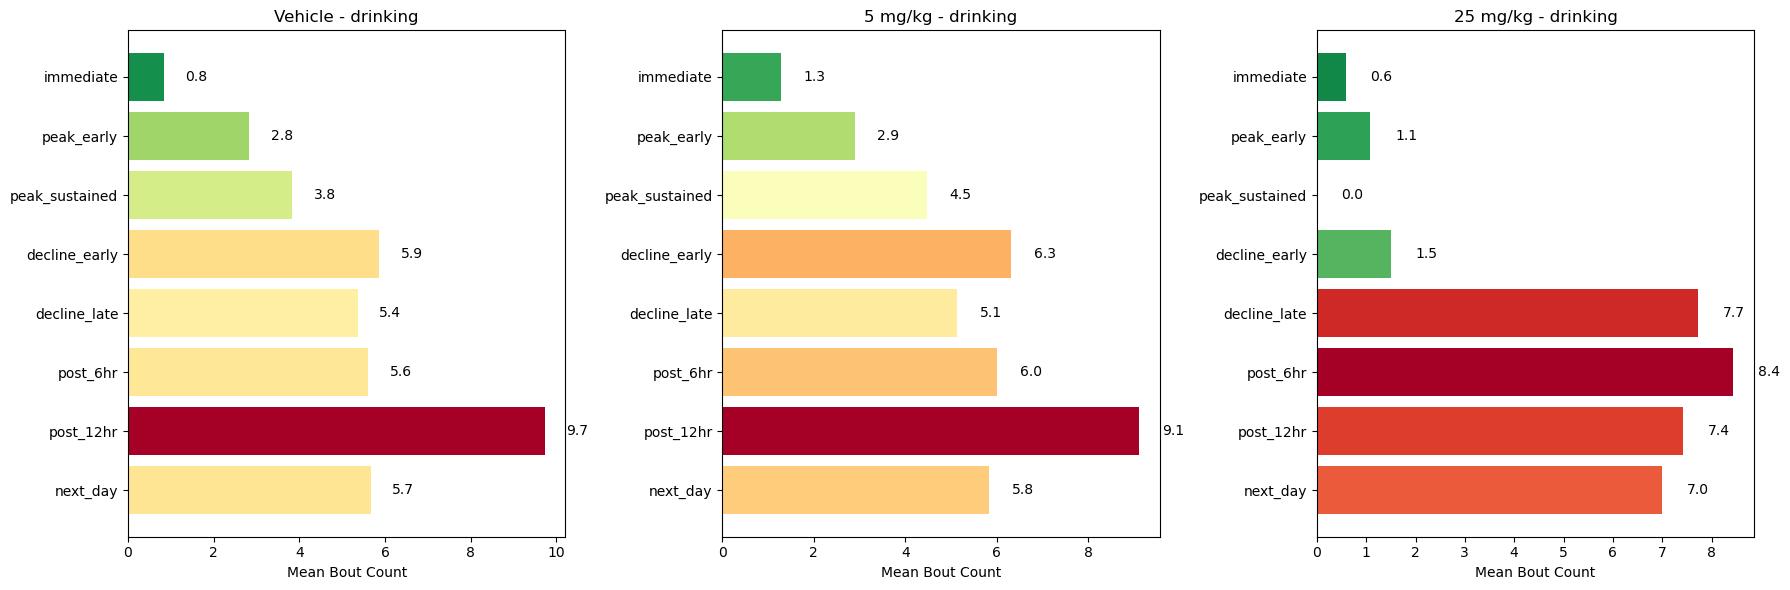

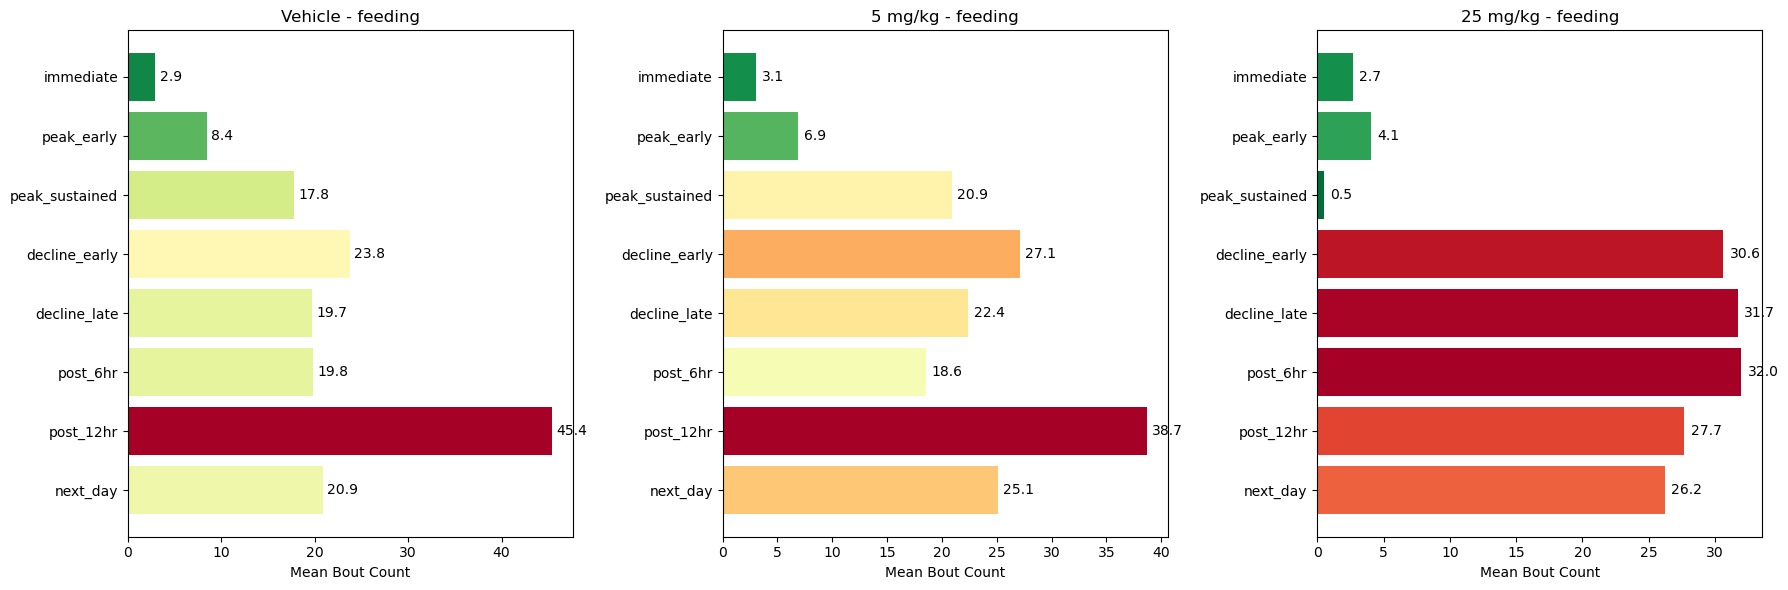

In [89]:
def compute_bout_count(df):
    """Count number of feeding/drinking bouts per window."""
    
    results = []
    
    for (animal_id, dose_group, event, name), animal_df in df.groupby(
        ['animal_id', 'dose_group', 'event', 'name']
    ):
        for window_name, (win_start, win_end) in TIME_WINDOWS.items():
            if window_name == 'baseline':
                continue
            
            window_data = animal_df[
                (animal_df['minutes_from_injection'] >= win_start) &
                (animal_df['minutes_from_injection'] < win_end)
            ]
            
            # Count timepoints where behavior occurred (value > 0)
            bout_count = (window_data['value'] > 0).sum()
            
            results.append({
                'animal_id': animal_id,
                'dose_group': dose_group,
                'event': event,
                'feature': name,
                'window': window_name,
                'bout_count': bout_count
            })
    
    return pd.DataFrame(results)

# Compute bout counts
bout_results = compute_bout_count(df_drinking)

# Summarize by dose group and window
bout_summary = bout_results.groupby(
    ['dose_group', 'feature', 'window']
)['bout_count'].mean().reset_index()

# Pivot for heatmap
def create_bout_heatmap(bout_results, feature_name):
    """Create heatmap for bout counts."""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for ax, dose in zip(axes, ['Vehicle', '5 mg/kg', '25 mg/kg']):
        # Filter and pivot
        dose_data = bout_results[
            (bout_results['dose_group'] == dose) &
            (bout_results['feature'] == feature_name)
        ]
        
        pivot = dose_data.groupby('window')['bout_count'].mean()
        pivot = pivot.reindex(WINDOW_ORDER)
        
        # Plot as horizontal bar for single feature
        colors = plt.cm.RdYlGn_r(pivot / pivot.max())
        ax.barh(WINDOW_ORDER, pivot.reindex(WINDOW_ORDER), color=colors)
        ax.set_xlabel('Mean Bout Count')
        ax.set_title(f'{dose} - {feature_name.replace("animal_bouts.", "")}')
        ax.invert_yaxis()
        
        # Add value labels
        for i, (window, count) in enumerate(pivot.reindex(WINDOW_ORDER).items()):
            ax.text(count + 0.5, i, f'{count:.1f}', va='center')
    
    plt.tight_layout()
    plt.savefig('bout_count_heatmap.png', dpi=150, bbox_inches='tight')
    plt.show()

# Create heatmaps for both features
create_bout_heatmap(bout_results, 'animal_bouts.drinking')
create_bout_heatmap(bout_results, 'animal_bouts.feeding')

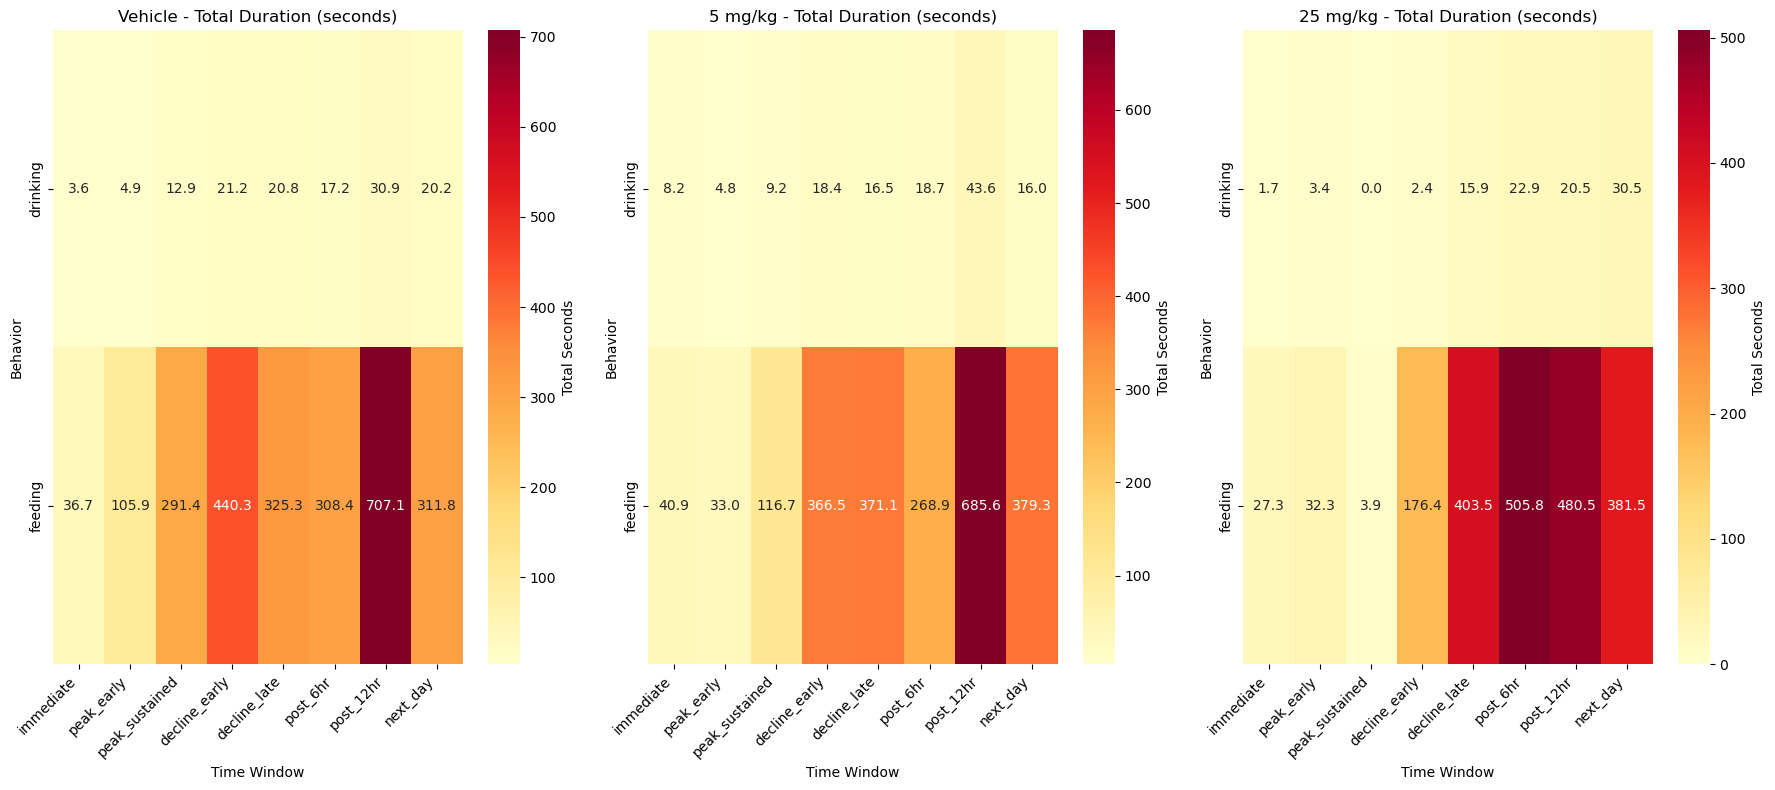

In [90]:
def compute_total_duration(df):
    """Compute total seconds spent feeding/drinking per window."""
    
    results = []
    
    for (animal_id, dose_group, event, name), animal_df in df.groupby(
        ['animal_id', 'dose_group', 'event', 'name']
    ):
        for window_name, (win_start, win_end) in TIME_WINDOWS.items():
            if window_name == 'baseline':
                continue
            
            window_data = animal_df[
                (animal_df['minutes_from_injection'] >= win_start) &
                (animal_df['minutes_from_injection'] < win_end)
            ]
            
            # Sum values and multiply by 60 (resolution) to get seconds
            # value is proportion of time, so value * 60 = seconds in that minute
            total_seconds = window_data['value'].sum() * 60
            
            results.append({
                'animal_id': animal_id,
                'dose_group': dose_group,
                'event': event,
                'feature': name,
                'window': window_name,
                'total_seconds': total_seconds
            })
    
    return pd.DataFrame(results)

# Compute total duration
duration_results = compute_total_duration(df_drinking)

# Create heatmap for total duration
def create_duration_heatmap(duration_results):
    """Create heatmap showing total duration for both features."""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 8))
    
    for ax, dose in zip(axes, ['Vehicle', '5 mg/kg', '25 mg/kg']):
        dose_data = duration_results[duration_results['dose_group'] == dose]
        
        # Pivot: rows = features, columns = windows
        pivot = dose_data.groupby(['feature', 'window'])['total_seconds'].mean().reset_index()
        heatmap_data = pivot.pivot(index='feature', columns='window', values='total_seconds')
        
        # Reorder columns
        heatmap_data = heatmap_data[[w for w in WINDOW_ORDER if w in heatmap_data.columns]]
        
        # Clean feature names
        heatmap_data.index = heatmap_data.index.str.replace('animal_bouts.', '')
        
        sns.heatmap(heatmap_data, ax=ax, cmap='YlOrRd', annot=True, fmt='.1f',
                    cbar_kws={'label': 'Total Seconds'})
        ax.set_title(f'{dose} - Total Duration (seconds)')
        ax.set_xlabel('Time Window')
        ax.set_ylabel('Behavior')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('total_duration_heatmap.png', dpi=150, bbox_inches='tight')
    plt.show()

create_duration_heatmap(duration_results)

In [91]:
# Compare metrics for 25 mg/kg drinking
print("=== 25 mg/kg Drinking Comparison ===\n")

print("Percent Change (original):")
pct = results_drinking[
    (results_drinking['dose_group'] == '25 mg/kg') &
    (results_drinking['feature'] == 'animal_bouts.drinking')
].groupby('window')['pct_change'].mean()
print(pct.reindex(WINDOW_ORDER).round(1))

print("\nBout Count:")
bouts = bout_results[
    (bout_results['dose_group'] == '25 mg/kg') &
    (bout_results['feature'] == 'animal_bouts.drinking')
].groupby('window')['bout_count'].mean()
print(bouts.reindex(WINDOW_ORDER).round(1))

print("\nTotal Duration (seconds):")
dur = duration_results[
    (duration_results['dose_group'] == '25 mg/kg') &
    (duration_results['feature'] == 'animal_bouts.drinking')
].groupby('window')['total_seconds'].mean()
print(dur.reindex(WINDOW_ORDER).round(1))

=== 25 mg/kg Drinking Comparison ===

Percent Change (original):
window
immediate         -75.7
peak_early        -16.3
peak_sustained   -100.0
decline_early     -63.0
decline_late       77.4
post_6hr          151.1
post_12hr          95.2
next_day          165.8
Name: pct_change, dtype: float64

Bout Count:
window
immediate         0.6
peak_early        1.1
peak_sustained    0.0
decline_early     1.5
decline_late      7.7
post_6hr          8.4
post_12hr         7.4
next_day          7.0
Name: bout_count, dtype: float64

Total Duration (seconds):
window
immediate          1.7
peak_early         3.4
peak_sustained     0.0
decline_early      2.4
decline_late      15.9
post_6hr          22.9
post_12hr         20.5
next_day          30.5
Name: total_seconds, dtype: float64
